## 回歸問題

競賽目標: 用 X 預測 Y(Fare Amount)

評估方式: RMSE    

https://www.kaggle.com/dster/nyc-taxi-fare-starter-kernel-simple-linear-model


### Ideas for Improvement

- The output here will score an RMSE of $5.74, but you can do better than that! Here are some suggestions:

    - Use more columns from the input data. Here we're only using the start/end GPS points from columns 
    [pickup|dropoff]_[latitude|longitude]. Try to see if the other columns -- pickup_datetime and passenger_count -- can help improve your results.

    - Use absolute location data rather than relative. Here we're only looking at the difference between the start and end points, 
    but maybe the actual values -- indicating where in NYC the taxi is traveling -- would be useful.

    - Use a non-linear model to capture more intricacies within the data.

    - Try to find more outliers to prune, or construct useful feature crosses.

    - Use the entire dataset -- here we're only using about 20% of the training data!



## Linear regression analysis with string/categorical features (variables)?

Yes, you will have to convert everything to numbers. That requires thinking about what these attributes represent.

Usually there are three possibilities:

1. One-Hot encoding for categorical data
1. Arbitrary numbers for ordinal data
1. Use something like group means for categorical data (e. g. mean prices for city districts).

You have to be carefull to not infuse information you do not have in the application case.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import os

# from datetime import datetime
import datetime
import calendar
import time
from functools import reduce

from sklearn.model_selection import train_test_split


import pymysql
import pandas as pd
import xlrd
from datetime import datetime

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
host = "127.0.0.1" # localhost

def connection(host):
    return pymysql.connect(host=host,
                           user='root', # 'collectionuser'
                           password='', # 'Collection000000user'
                           db='NYC_taxi',
                           use_unicode=True,
                           charset="utf8")
# 從 SQL 選到 Python
def read_sql_to_pyList(sql, x) :
    """
    x 要是 list 的形式喔，不然這裡參數的位置就要放 [x] 而不是 x
    """
                      #"snk-prod.cluster-ro-c4ajpvm491zl.eu-west-1.rds.amazonaws.com"
    conn = connection(host)
    cur = conn.cursor()
#   df = pd.read_sql(sql, conn).rename(columns = {"nameRe" : "NameRe"})
    cur.execute(sql, x)
    resultSet = list(cur.fetchall())
    conn.close()
    return resultSet


# 從 SQL 選到 Python
def read_sql_to_pyList_noVar(sql) : # df = pd.read_sql(sql, conn).rename(columns = {"nameRe" : "NameRe"})
    conn = connection(host)
    cur = conn.cursor()  
    cur.execute(sql)
    resultSet = list(cur.fetchall())
    conn.close()
    return resultSet


# 從 Python 寫到 SQL
def execute_sql(sql) :
                      #"snk-prod.cluster-ro-c4ajpvm491zl.eu-west-1.rds.amazonaws.com"
    conn = connection(host)
    cur = conn.cursor()
    try :
        cur.execute(sql)
        conn.commit()  
    except Exception as e :
        conn.rollback()
        print(e)
    finally :    
        conn.close()


# 從 Python 寫到 SQL withPyVar
def execute_sql_withPyVar(sql, x) :
    """
    x 要是 list 的形式喔，不然這裡參數的位置就要放 [x] 而不是 x
    """
                      #"snk-prod.cluster-ro-c4ajpvm491zl.eu-west-1.rds.amazonaws.com"
    conn = connection(host)
    cur = conn.cursor()
    try :
        cur.execute(sql, x)
        conn.commit()  
    except Exception as e :
        conn.rollback()
        print(e)
    finally :    
        conn.close()

## 檢查資料欄位以利匯進sql、快速檢視資料內容

In [3]:
# paths

print("os.path.sep: ", os.path.sep)
print("--")
folder_path = os.path.join(os.path.sep, "Users", "HP", "py_ds", "win10", "NYC_taxi", "data")
print("listdir: ", os.listdir(folder_path))
print("--")
train_path = os.path.join(folder_path, "train.csv")
print("train_path: ", train_path, "\n")
test_path = os.path.join(folder_path, "test.csv")
print("test_path: ", test_path, "\n")

os.path.sep:  \
--
listdir:  ['.ipynb_checkpoints', 'GCP-Coupons-Instructions.rtf', 'NYC_taxi.ipynb', 'NYC_taxi.sqlite3', 'NYC_Taxi_Time_Analysis_and_OOF_LGBM.ipynb', 'sample_submission.csv', 'test.csv', 'train.csv', 'Untitled.ipynb']
--
train_path:  \Users\HP\py_ds\win10\NYC_taxi\data\train.csv 

test_path:  \Users\HP\py_ds\win10\NYC_taxi\data\test.csv 



In [4]:
# check data
#------
df_train = pd.read_csv(train_path, nrows = 5) # only reads 5 rows
print(df_train.dtypes)
df_train

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


## 把資料匯進sql

--

## 如何在MySQL上快速匯入大量的巨大csv
https://tnlin.wordpress.com/2017/02/25/%E5%A6%82%E4%BD%95%E5%9C%A8mysql%E5%8C%AF%E5%85%A5%E5%A4%A7%E9%87%8F%E7%9A%84%E5%B7%A8%E5%9E%8Bcsv/

In [5]:
# # put data into sql table
# # ------

# # 如果数据表已经存在使用 execute() 方法删除表。
# sql = """
# DROP TABLE IF EXISTS train_csv_20191023
# """
# try :
#     execute_sql(sql)
# except Exception as e :
#     print(e)
#     pass


# # create table & columns & datatype of each column --------------- 關於日期部份，不能有"-" : 2017-01-01 -> 20170101
# sql = """
# CREATE TABLE train_csv_20191023 (
#              trainind_data_key DATETIME,
#              fare_amount DECIMAL(8, 4),
#              pickup_datetime DATETIME, 
#              pickup_longitude DECIMAL(10, 6),
#              pickup_latitude DECIMAL(10, 6),  
#              dropoff_longitude DECIMAL(10, 6),
#              dropoff_latitude DECIMAL(10, 6),
#              passenger_count INT
#              );"""         
# execute_sql(sql)





# # 20191023 把 LOAD DATA LOCAL INFILE 拿掉LOCAL變成LOAD DATA INFILE 就好了

# sql = """
# LOAD DATA INFILE 'C:/Users/HP/py_ds/win10/NYC_taxi/data/train.csv' 
# INTO TABLE train_csv_20191023
# FIELDS TERMINATED BY ',' 
# LINES TERMINATED BY '\n'
# IGNORE 1 LINES
# (
# trainind_data_key, fare_amount, pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count
# );"""


# execute_sql(sql)

## 第一步 暸解train data的資料外觀與內容

- df = pd.read_csv() : 讀取資料

- train.head() : 了解資料的大概情況，不要用print()會比較完整而且好看

- train.shape : 資料維度

- train.info()
> train.dtypes : 每一筆資料的儲存狀態(是integer, float, object等等)

- train.describe() : the function "summary" in R

- train.isnull().sum() : 一口氣了解有多少遺漏值
> 用計算幾個來衡量不太準，應該用比例來衡量(不然萬一樣本數本來就不同，直接計數去比較很容易誤判 -> 用normalize = True來改用比例去衡量)
bar_plotting()

In [7]:
# load data
df_train =  pd.read_csv(os.path.join(folder_path, "train.csv"), nrows = 6_000_000) # 6_000_000  , 1_000_000 , 1000
df_test =  pd.read_csv(os.path.join(folder_path, "test.csv"))

In [8]:
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [9]:
df_test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [10]:
print("train shape: ", df_train.shape, " ; ", "test shape: ", df_test.shape)
print("--")
print("columns that test data doesn't have (usually the Y):", set(list(df_train.columns)) - set(list(df_test)))
print("--")
df_train.info()

train shape:  (6000000, 8)  ;  test shape:  (9914, 7)
--
columns that test data doesn't have (usually the Y): {'fare_amount'}
--
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: float64(5), int64(1), object(2)
memory usage: 366.2+ MB


In [11]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,6.000000e+06,6.000000e+06,6.000000e+06,5.999961e+06,5.999961e+06,6.000000e+06
mean,1.134049e+01,-7.251142e+01,3.992406e+01,-7.251060e+01,3.992049e+01,1.684645e+00
std,9.810989e+00,1.280236e+01,9.022813e+00,1.285400e+01,9.367604e+00,1.327794e+00
min,-1.000000e+02,-3.426609e+03,-3.488080e+03,-3.412653e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073491e+01,-7.399139e+01,4.073404e+01,1.000000e+00
50%,8.500000e+00,-7.398182e+01,4.075263e+01,-7.398016e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076712e+01,-7.396367e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,3.344459e+03,3.457622e+03,3.345917e+03,2.080000e+02


---

## 第二步 train data 的 資料預處理 (Preprocessing, Feature Engineering)、EDA

- X 不要納入編號（PassengerId, Ticket）、姓名（Name）與遺漏值過多的變數（Cabin）

- 填補/刪除遺漏值 : Embarked, Age

- one-hot encoding 進行類別標籤編碼轉換 : Sex, Embarked

train_sex_embarked_dummies = pd.get_dummies(train.loc[:, ["Sex", "Embarked"]])

train_sex_embarked_ohe = train_sex_embarked_dummies.values.astype(float)

透過.values先換成ndarray。為什麼要轉換過來呢?因為等等要資料水平合併、透過ndarray跑計算阿

train_sex_embarked_dummies.head()

## <font color="red"> Preprocessing </font>

https://www.kaggle.com/madhurisivalenka/cleansing-eda-modelling-lgbm-xgboost-starters

## PART 1 --> DATA CLEANSING & EXPLORATORY DATA ANALYSIS (EDA)

Will perform the following activities

1. Shape of train and test sets
1. Check for NaNs and drop them (if any)
1. Check for outliers and drop them (if any)
1. Type conversion of relevant fields

## PART 2 --> MODELLING AND PREDICTION

FINALLY! Data cleansing is done! Now to split the x and y variables and proceed to modelling. I shall use the random forest method for prediction

https://www.kaggle.com/aiswaryaramachandran/eda-and-feature-engineering

##  Convert pickup_datetime from Object to Datetime object
> Create datetime features based on pickup_datetime


## Check for Missing Values



## Exploratory Data Analysis
> Distribution of Trip Fare


## Let us look at Geographical Features and their relationship with Fare Amount
> Distribution of Pickup and Dropoff Lat Lng

> The data is for Taxi Rides in Newyork, whose center lat, lng is at ((40,-74).The range of dropoff and pickup latitudes indicates lot of outlier locations in the train data.

> Let us set the boundary for the train data also based on test data lat lng boundaries.We will mark the outlier locations as 1 and remove them for further analysis

> There are a lot of cases where lat lng is zero. How many such cases are there in the data?

> 114K records have either pickup/dropoff lat/lng as 0.0 . There is a high chance this is present in test data as well. So, let us create a field called is_outlier_loc and mark as 1 in case it is an outlier. Any point beyond NYC border is an outlier. We will also drop all rows where the pickup or dropoff location is an outlier



##  Plot Heatmap of Pickups and Dropoffs within NYC




## Heatmap based on fare amount across NYC



## In the scatter plot, we saw the high density of pickups and dropoffs from and to JFK and La Guardia Airport
> Let us look at over time how fares are from La Guardia and JFK

> What is the Average Fare amount of trips from JFK

> Distribution of fare amount for both pickup and dropoff to JFK is similar



## Trip Distance
> The fare seems to be fixed for trip distances > 50 miles. Normally airports pickup or dropoff have fixed prices. We can remove the airport pickup and dropoff and plot the distribution of Fare Amount vs Trip distribution

> In the plot above, we can see two clusters with linear realtionship between taxi fare and distance. But for trip distances >50miles, though a linear relationship exists,the fare amount is very low. Let us check where these trips originate and end

> Most of the long trips dropoffs and pickups are in lower Manhattan. There are a lot of dropoffs in Brooklyn

> New York city is divided into 7 Boroughs. Let us calculate which borough pickup and dropoff points are. And whether that effects the fare


## How does the tripfare vary across (pickup) buroughs
> There is a significant difference in pickups and dropoffs fare amount for each burough exceept Manhattan. We can see pickups from Queens is expensive compared to pickups from other Buroughs.Very high difference in pickup and dropoff prices for Staten Island.

> Dropoffs to Bronx and Staten island are long trips. In Manhattan the pickup and dropoffs fare amount has similar distribution. Let us add a field, is_lower_manhattan as we had seen above that dropoffs to lower manhattan had higher trip distance but lower fare

> How does Fare Amount differ for pickups and dropoff for Lower Manhattan compared to rest of Manhattan

> The distribution of trip distance and fare amount for Lower Manhattan pickups and dropoffs is very different. Also, slope of linear realtionship for pickups for Lower Manhattan is higher than that for Rest of Manhattan


## Let us now look at datetime features and their realtionship with Fare Amount
> What is the time period in out sample

> Avg Fare amount has beern increasing over the years.

    > groupandplot





## How does Number of passengers affect Fare time



---

https://www.kaggle.com/madhurisivalenka/cleansing-eda-modelling-lgbm-xgboost-starters

## PART 1 --> DATA CLEANSING & EXPLORATORY DATA ANALYSIS (EDA)

Will perform the following activities

1. Shape of train and test sets
1. Check for NaNs and drop them (if any)
1. Check for outliers and drop them (if any)
1. Type conversion of relevant fields


--



## Now, for EDA. The following are my considerations -

- Does the number of passengers affect the fare?
- Does the date and time of pickup affect the fare?
- Does the day of the week affect the fare?
- Does the distance travelled affect the fare?
- First, let's split the datetime field 'pickup_datetime' to the following -



- year
- month
- date
- hour
- day of week
- Using these we shall calculate the day of the week and come to our conclusions about how pickup_location affects the fare. Also, create a new field 'distance' to fetch the distance between the pickup and the drop.

We can calulate the distance in a sphere when latitudes and longitudes are given by [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula)

haversine(θ) = sin²(θ/2)

Eventually, the formual boils down to the following where φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km) to include latitude and longitude coordinates (A and B in this case).

a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)

c = 2 * atan2( √a, √(1−a) )

d = R ⋅ c

d = Haversine distance

Refer [this page](https://community.esri.com/groups/coordinate-reference-systems/blog/2017/10/05/haversine-formula) for more info and examples on Haversine formula

## 匯入資料

In [12]:
# df_train =  pd.read_csv(os.path.join(folder_path, "train.csv"), nrows = 1_00_000) # 10000
# # df_test =  pd.read_csv(os.path.join(folder_path, "test.csv"), nrows = 20)

In [13]:
df_train.isnull().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    39
dropoff_latitude     39
passenger_count       0
dtype: int64

In [14]:
df_train.drop(df_train[df_train.isnull().any(1)].index, axis = 0)
df_train.shape

(6000000, 8)

In [15]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data)
    
    
print("\n << na_check(train) >>")
display(na_check(df_train))


 << na_check(train) >>


,Missing Ratio
dropoff_latitude,0.00065
dropoff_longitude,0.00065


None

In [16]:
# drop nans
df_train = df_train.drop(df_train[df_train.isnull().any(1)].index, axis = 0)

## 初步查看資料，並找出不合理的值

In [17]:
# df_train.hist()

In [18]:
df_train.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

<< fare_amount >>
第 10 百分位數 ： 4.5
第 20 百分位數 ： 5.5
第 30 百分位數 ： 6.5
第 40 百分位數 ： 7.3
第 50 百分位數 ： 8.5
第 60 百分位數 ： 9.7
第 70 百分位數 ： 11.5
第 80 百分位數 ： 14.1
第 90 百分位數 ： 20.5

<< Summary statistics >> 
count    5.999961e+06
mean     1.134044e+01
std      9.810895e+00
min     -1.000000e+02
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      1.273310e+03
Name: fare_amount, dtype: float64


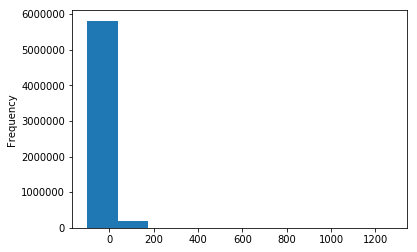

<< pickup_longitude >>
第 10 百分位數 ： -74.002782
第 20 百分位數 ： -73.99458299999999
第 30 百分位數 ： -73.99008178710938
第 40 百分位數 ： -73.985853
第 50 百分位數 ： -73.981817
第 60 百分位數 ： -73.977301
第 70 百分位數 ： -73.97126800000001
第 80 百分位數 ： -73.96204
第 90 百分位數 ： -73.950764

<< Summary statistics >> 
count    5.999961e+06
mean    -7.251148e+01
std      1.280223e+01
min     -3.426609e+03
25%     -7.399207e+01
50%     -7.398182e+01
75%     -7.396711e+01
max      3.439426e+03
Name: pickup_longitude, dtype: float64


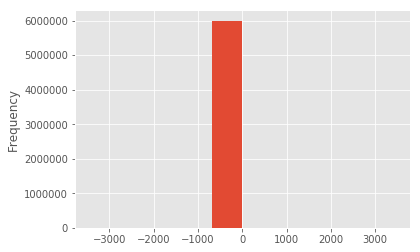

<< pickup_latitude >>
第 10 百分位數 ： 40.718259
第 20 百分位數 ： 40.730038
第 30 百分位數 ： 40.739594
第 40 百分位數 ： 40.746666999999995
第 50 百分位數 ： 40.752631
第 60 百分位數 ： 40.758676
第 70 百分位數 ： 40.763921999999994
第 80 百分位數 ： 40.770949
第 90 百分位數 ： 40.779787

<< Summary statistics >> 
count    5.999961e+06
mean     3.992409e+01
std      9.022769e+00
min     -3.488080e+03
25%      4.073491e+01
50%      4.075263e+01
75%      4.076712e+01
max      3.344459e+03
Name: pickup_latitude, dtype: float64


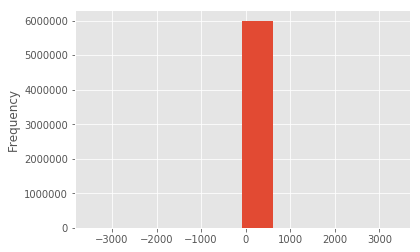

<< dropoff_longitude >>
第 10 百分位數 ： -74.002905
第 20 百分位數 ： -73.99414399999999
第 30 百分位數 ： -73.9892
第 40 百分位數 ： -73.984415
第 50 百分位數 ： -73.98015699999999
第 60 百分位數 ： -73.975387
第 70 百分位數 ： -73.96882
第 80 百分位數 ： -73.958465
第 90 百分位數 ： -73.94554901123048

<< Summary statistics >> 
count    5.999961e+06
mean    -7.251060e+01
std      1.285400e+01
min     -3.412653e+03
25%     -7.399139e+01
50%     -7.398016e+01
75%     -7.396367e+01
max      3.457622e+03
Name: dropoff_longitude, dtype: float64


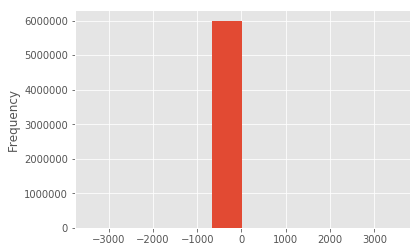

<< dropoff_latitude >>
第 10 百分位數 ： 40.71337
第 20 百分位數 ： 40.728155
第 30 百分位數 ： 40.73922
第 40 百分位數 ： 40.747223
第 50 百分位數 ： 40.75316
第 60 百分位數 ： 40.759021999999995
第 70 百分位數 ： 40.764378
第 80 百分位數 ： 40.772472
第 90 百分位數 ： 40.782781

<< Summary statistics >> 
count    5.999961e+06
mean     3.992049e+01
std      9.367604e+00
min     -3.488080e+03
25%      4.073404e+01
50%      4.075316e+01
75%      4.076811e+01
max      3.345917e+03
Name: dropoff_latitude, dtype: float64


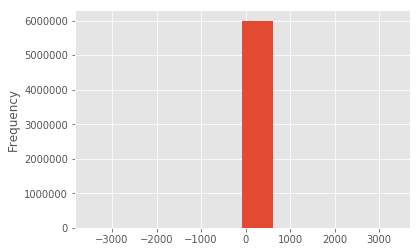

<< passenger_count >>
第 10 百分位數 ： 1.0
第 20 百分位數 ： 1.0
第 30 百分位數 ： 1.0
第 40 百分位數 ： 1.0
第 50 百分位數 ： 1.0
第 60 百分位數 ： 1.0
第 70 百分位數 ： 2.0
第 80 百分位數 ： 2.0
第 90 百分位數 ： 4.0

<< Summary statistics >> 
count    5.999961e+06
mean     1.684656e+00
std      1.327791e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.080000e+02
Name: passenger_count, dtype: float64


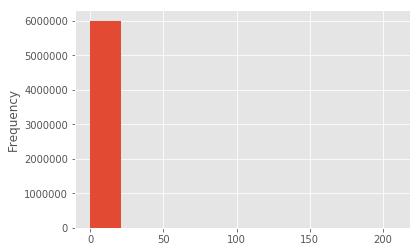

In [19]:
EDA_cols = [x for x in list(df_train.columns) if x not in ["key", "pickup_datetime"]]

def quick_plot():
    # 快速列出百分位數、summary
    # https://nbviewer.jupyter.org/github/jshuang0520/2nd-ML100Days/blob/master/homework/Day_005_HW/Day_005_HW.ipynb
    def printPercentile(df, x) :
        print("<< %s >>" % x)
        for i in range(10, 91, 10):
            print("第 %s 百分位數 ： %s" % (i, np.percentile(df[x], i)))
        print("\n<< Summary statistics >> \n%s" % df[x].describe())

    for x in EDA_cols :

        df_train[x].plot(kind = "hist")

        plt.style.use("ggplot")
        printPercentile(df_train, x)
        plt.show()
quick_plot()

In [20]:
df_train.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [21]:
from collections import Counter

print("fare < 0: %s rows" % Counter(df_train['fare_amount'] < 0)[True])
print("--")
print("pickup_lon < -180 or > 180: %s rows" % Counter((df_train['pickup_longitude'] < -180) | (df_train['pickup_longitude'] > 180))[True])
print("--")
print("pickup_lat < -90 or > 90: %s rows" % Counter((df_train['pickup_latitude'] < -90) | (df_train['pickup_latitude'] > 90))[True])
print("--")
print("dropoff_lon < -180 or > 180: %s rows" % Counter((df_train['dropoff_longitude'] < -180) | (df_train['dropoff_longitude'] > 180))[True])
print("--")
print("dropoff_lat < -90 or > 90: %s rows" % Counter((df_train['dropoff_latitude'] < -90) | (df_train['dropoff_latitude'] > 90))[True])
print("--")
print("passenger_cnt == 0 or > 6: %s rows" % Counter((df_train['passenger_count'] == 0) | (df_train['passenger_count'] > 6))[True])
print("--")


fare < 0: 262 rows
--
pickup_lon < -180 or > 180: 120 rows
--
pickup_lat < -90 or > 90: 100 rows
--
dropoff_lon < -180 or > 180: 124 rows
--
dropoff_lat < -90 or > 90: 99 rows
--
passenger_cnt == 0 or > 6: 21187 rows
--


In [22]:
df_train.shape

(5999961, 8)

In [23]:
df_train = df_train.drop(df_train[df_train['fare_amount'] < 0].index, axis = 0)
df_train.shape

(5999699, 8)

In [24]:
df_train = df_train.drop(df_train[(df_train['pickup_longitude'] < -180) | (df_train['pickup_longitude'] > 180) |
                                  (df_train['pickup_latitude'] < -90) | (df_train['pickup_latitude'] > 90) |
                                  (df_train['dropoff_longitude'] < -180) | (df_train['dropoff_longitude'] > 180) |
                                  (df_train['dropoff_latitude'] < -90) | (df_train['dropoff_latitude'] > 90)
                                 ].index, axis = 0)
df_train.shape

(5999421, 8)

In [25]:
df_train = df_train.drop(df_train[(df_train['passenger_count'] == 0) | (df_train['passenger_count'] > 6)].index, axis = 0)
df_train.shape

(5978236, 8)

## Location data
As we're dealing with location data, I want to plot the coordinates on a map. This gives a better view of the data. For this, I use the following website:


Easy to use map and GPS tool: https://www.gps-coordinates.net/

Calculate distance between locations: https://www.travelmath.com/flying-distance/

Open street map to grab using bouding box a map: https://www.openstreetmap.org/export#map=8/52.154/5.295

New York city coordinates are (https://www.travelmath.com/cities/New+York,+NY):


longitude = -74.0063889

lattitude = 40.7141667

I define a bounding box of interest by [long_min, long_max, latt_min, latt_max] using the minimum and maximum coordinates from the testset. This way, I'm sure to train a model for the full pickup/dropoff coordinate range of the test set.

From Open Street Map I grab a map and I drop any datapoint outside this box.

In [26]:
# minimum and maximum longitude test set
min(df_test.pickup_longitude.min(), df_test.dropoff_longitude.min()), \
max(df_test.pickup_longitude.max(), df_test.dropoff_longitude.max())

(-74.263242, -72.986532)

In [27]:
# minimum and maximum latitude test
min(df_test.pickup_latitude.min(), df_test.dropoff_latitude.min()), \
max(df_test.pickup_latitude.max(), df_test.dropoff_latitude.max())

(40.568973, 41.709555)

In [28]:
import matplotlib.pyplot as plt

In [29]:
# this function will also be used with the test set below
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
           

In [30]:
# load image of NYC map
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

In [31]:
print('Old size: %d' % len(df_train))
df_train = df_train[select_within_boundingbox(df_train, BB)]
print('New size: %d' % len(df_train))

Old size: 5978236
New size: 5851935


In [32]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

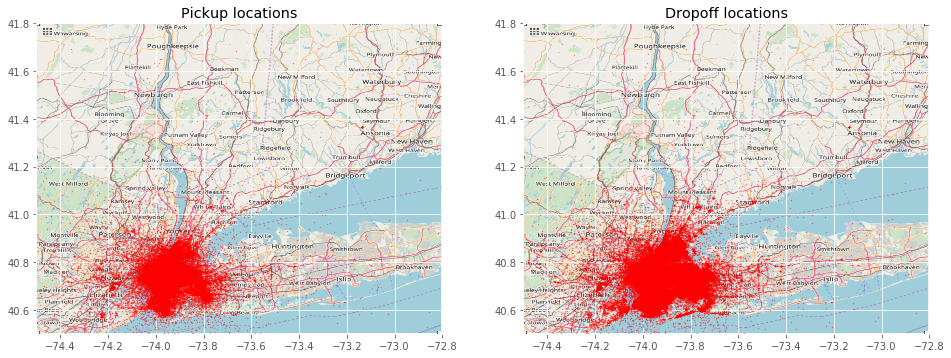

In [33]:
# plot training data on map
plot_on_map(df_train, BB, nyc_map, s=1, alpha=0.3)

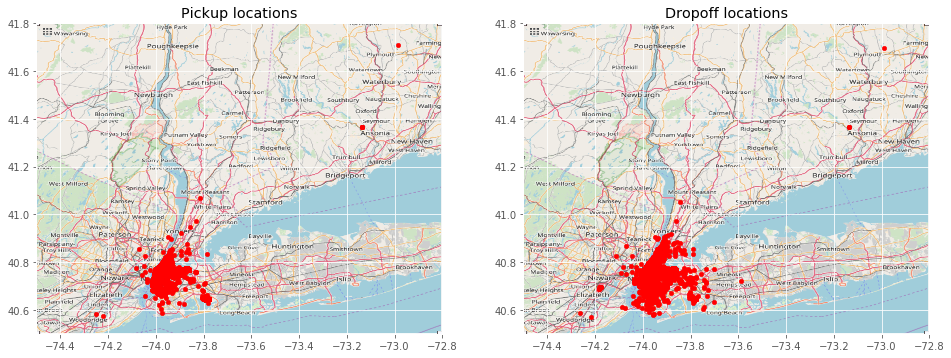

In [34]:
# plot test data on map
plot_on_map(df_test, BB, nyc_map, alpha=1.0, s=20)

### training data 地圖放大再畫一次

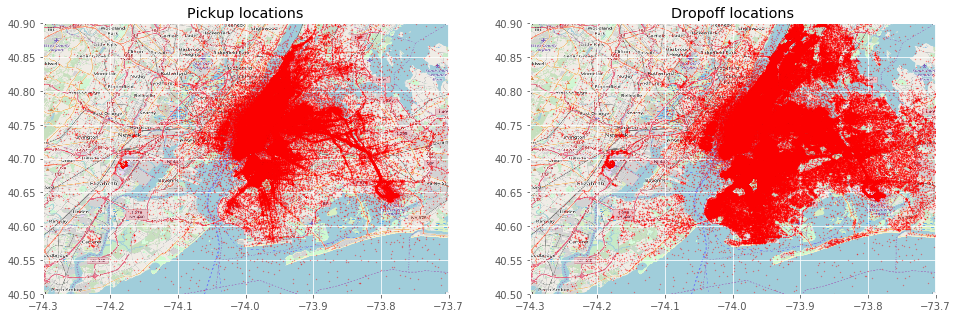

In [35]:
# plot training data on map zoomed in
plot_on_map(df_train, BB_zoom, nyc_map_zoom, s=1, alpha=0.3)

## Removing datapoints in water

As can be seen from the map + scatter plots above, some datapoints are located in the water. 

These are obviously noisy datapoints. 

To remove these datapoints, I create a boolean land/water map from the NYC map. 

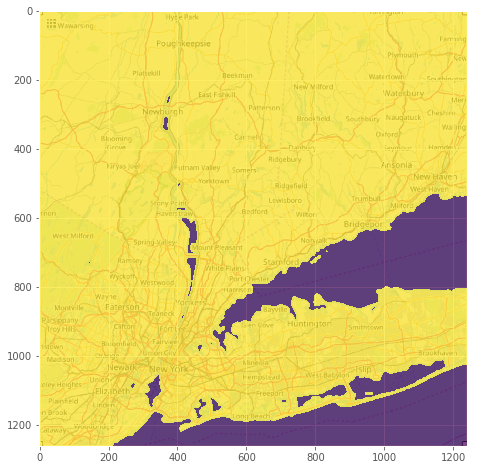

In [36]:
# read nyc mask and turn into boolean map with
# land = True, water = False
nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9

plt.figure(figsize=(8,8))
plt.imshow(nyc_map, zorder=0)

# note: True is show in yellow(land), False in purple(water).
plt.imshow(nyc_mask, zorder=1, alpha=0.7); # note: True is show in black, False in white.

In [37]:
# translate longitude/latitude coordinate into image xy coordinate
def lonlat_to_xy(longitude, latitude, dx, dy, BB):
    return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')
"""
# load image of NYC map
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')


# read nyc mask and turn into boolean map with
# land = True, water = False
nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
"""

pickup_x, pickup_y = lonlat_to_xy(df_train.pickup_longitude, df_train.pickup_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)

dropoff_x, dropoff_y = lonlat_to_xy(df_train.dropoff_longitude, df_train.dropoff_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)

In [38]:
idx = (nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x])
print("Number of trips in water: {}".format(np.sum(~idx)))

Number of trips in water: 1184


In [39]:
def remove_datapoints_from_water(df):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

    # define bounding box
    BB = (-74.5, -72.8, 40.5, 41.8)
    
    # read nyc mask and turn into boolean map with
    # land = True, water = False
    nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
    
    # calculate for each lon,lat coordinate the xy coordinate in the mask map
    pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)    
    # calculate boolean index
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]
    
    # return only datapoints on land
    return df[idx]

In [40]:
print('Old size: %d' % len(df_train))
df_train = remove_datapoints_from_water(df_train)
print('New size: %d' % len(df_train))

Old size: 5851935
New size: 5850751


<< fare_amount >>
第 10 百分位數 ： 4.5
第 20 百分位數 ： 5.5
第 30 百分位數 ： 6.5
第 40 百分位數 ： 7.3
第 50 百分位數 ： 8.5
第 60 百分位數 ： 9.7
第 70 百分位數 ： 11.5
第 80 百分位數 ： 14.1
第 90 百分位數 ： 20.5

<< Summary statistics >> 
count    5.850751e+06
mean     1.132773e+01
std      9.688888e+00
min      0.000000e+00
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      9.520000e+02
Name: fare_amount, dtype: float64


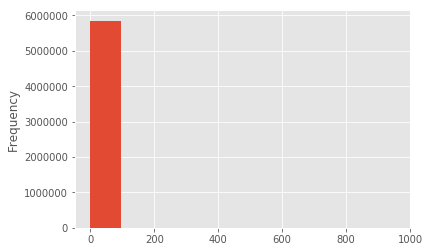

<< pickup_longitude >>
第 10 百分位數 ： -74.002899
第 20 百分位數 ： -73.994785
第 30 百分位數 ： -73.99033100000001
第 40 百分位數 ： -73.98620799999999
第 50 百分位數 ： -73.98210300000001
第 60 百分位數 ： -73.977879
第 70 百分位數 ： -73.97221374511719
第 80 百分位數 ： -73.96366
第 90 百分位數 ： -73.953314

<< Summary statistics >> 
count    5.850751e+06
mean    -7.397516e+01
std      3.838611e-02
min     -7.449650e+01
25%     -7.399228e+01
50%     -7.398210e+01
75%     -7.396833e+01
max     -7.281258e+01
Name: pickup_longitude, dtype: float64


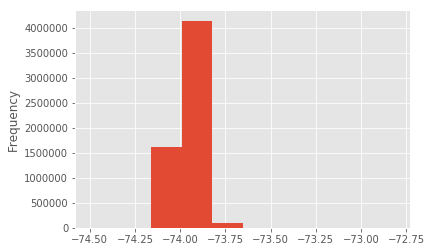

<< pickup_latitude >>
第 10 百分位數 ： 40.72066879272461
第 20 百分位數 ： 40.731697
第 30 百分位數 ： 40.740522
第 40 百分位數 ： 40.747659999999996
第 50 百分位數 ： 40.753353000000004
第 60 百分位數 ： 40.759115
第 70 百分位數 ： 40.764174
第 80 百分位數 ： 40.771262
第 90 百分位數 ： 40.780015

<< Summary statistics >> 
count    5.850751e+06
mean     4.075109e+01
std      2.949281e-02
min      4.050005e+01
25%      4.073657e+01
50%      4.075335e+01
75%      4.076754e+01
max      4.169685e+01
Name: pickup_latitude, dtype: float64


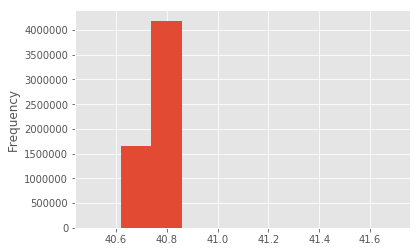

<< dropoff_longitude >>
第 10 百分位數 ： -74.003085
第 20 百分位數 ： -73.99441528320312
第 30 百分位數 ： -73.989487
第 40 百分位數 ： -73.984775
第 50 百分位數 ： -73.98060799999999
第 60 百分位數 ： -73.976027
第 70 百分位數 ： -73.970021
第 80 百分位數 ： -73.960178
第 90 百分位數 ： -73.94925689697266

<< Summary statistics >> 
count    5.850751e+06
mean    -7.397430e+01
std      3.753549e-02
min     -7.449991e+01
25%     -7.399158e+01
50%     -7.398061e+01
75%     -7.396536e+01
max     -7.281783e+01
Name: dropoff_longitude, dtype: float64


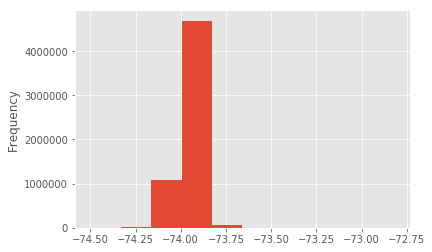

<< dropoff_latitude >>
第 10 百分位數 ： 40.716899
第 20 百分位數 ： 40.730097
第 30 百分位數 ： 40.74033
第 40 百分位數 ： 40.748221
第 50 百分位數 ： 40.753873
第 60 百分位數 ： 40.759440000000005
第 70 百分位數 ： 40.764688
第 80 百分位數 ： 40.772839000000005
第 90 百分位數 ： 40.783035999999996

<< Summary statistics >> 
count    5.850751e+06
mean     4.075147e+01
std      3.270861e-02
min      4.050005e+01
25%      4.073561e+01
50%      4.075387e+01
75%      4.076841e+01
max      4.171463e+01
Name: dropoff_latitude, dtype: float64


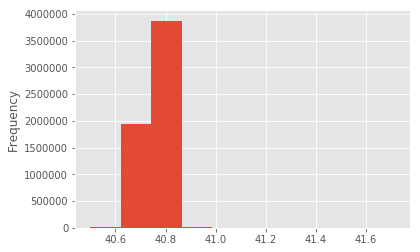

<< passenger_count >>
第 10 百分位數 ： 1.0
第 20 百分位數 ： 1.0
第 30 百分位數 ： 1.0
第 40 百分位數 ： 1.0
第 50 百分位數 ： 1.0
第 60 百分位數 ： 1.0
第 70 百分位數 ： 2.0
第 80 百分位數 ： 2.0
第 90 百分位數 ： 4.0

<< Summary statistics >> 
count    5.850751e+06
mean     1.690381e+00
std      1.305966e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      6.000000e+00
Name: passenger_count, dtype: float64


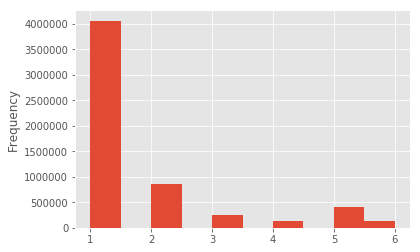

In [41]:
EDA_cols = [x for x in list(df_train.columns) if x not in ["key", "pickup_datetime"]]

def quick_plot():
    # 快速列出百分位數、summary
    # https://nbviewer.jupyter.org/github/jshuang0520/2nd-ML100Days/blob/master/homework/Day_005_HW/Day_005_HW.ipynb
    def printPercentile(df, x) :
        print("<< %s >>" % x)
        for i in range(10, 91, 10):
            print("第 %s 百分位數 ： %s" % (i, np.percentile(df[x], i)))
        print("\n<< Summary statistics >> \n%s" % df[x].describe())

    for x in EDA_cols :

        df_train[x].plot(kind = "hist")

        plt.style.use("ggplot")
        printPercentile(df_train, x)
        plt.show()
quick_plot()

In [42]:
# # 快速列出百分位數、summary
# # https://nbviewer.jupyter.org/github/jshuang0520/2nd-ML100Days/blob/master/homework/Day_005_HW/Day_005_HW.ipynb
    
# def printPercentile(df, x) :
#     print("<< %s >>" % x)
#     for i in range(10, 91, 10):
#         print("第 %s 百分位數 ： %s" % (i, np.percentile(df[x], i)))
#     print("\n<< Summary statistics >> \n%s" % df[x].describe())

    
# df_train["passenger_count"].plot(kind = "hist")

# plt.style.use("ggplot")
# printPercentile(df_train, "passenger_count")

## 特徵工程

## feature 1. key 根本就跟 pickup_datetime 一樣了吧，只是提交檔需要他

In [43]:
# 不過整理過程中看得礙眼 先拿掉吧
# del df_train['key']
# df = df.drop(['fare_amount'] , axis=1)
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


## feature 2. pickup_datetime(日期時間)

https://nbviewer.jupyter.org/github/jshuang0520/2nd-ML100Days/blob/master/homework/Day_025_HW/Day_025_HW.ipynb

In [44]:
# data = [df_train, df_test]
# # method 1 - 缺點: 要使用 .dt. 尤其dayofweek不同家的函數定義會混淆是星期幾 ； 而使用dt後也無法變回str做字串切割處理
# for i in data:
#     i['Year'] = i['pickup_datetime'].dt.year
#     i['Month'] = i['pickup_datetime'].dt.month
#     i['Day'] = i['pickup_datetime'].dt.day
#     i['Day_of_Week'] = i['pickup_datetime'].dt.dayofweek
#     i['Hour'] = i['pickup_datetime'].dt.hour




# # method 2 -  缺點: dayofweek光從字串很難做出
# df_train["Year"] = df_train['pickup_datetime'].apply(lambda x: x.split(" ")[0].split("-")[0]).apply(lambda x: int(x))
# df_train["Month"] = df_train["pickup_datetime"].apply(lambda x: x.split(" ")[0].split("-")[1]).apply(lambda x: int(x))
# df_train["Day"] = df_train["pickup_datetime"].apply(lambda x: x.split(" ")[0].split("-")[2]).apply(lambda x: int(x))
# df_train["Hour"] = df_train["pickup_datetime"].apply(lambda x: x.split(" ")[1].split(":")[0]).apply(lambda x: int(x))
# df_train["Minute"] = df_train["pickup_datetime"].apply(lambda x: x.split(" ")[1].split(":")[1]).apply(lambda x: int(x))






# # method 3
# # Convert pickup_datetime from Object to Datetime object¶
# df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S UTC')
# df_train['pickup_date']= df_train['pickup_datetime'].dt.date

# df_train['Year']=df_train['pickup_datetime'].apply(lambda x: x.year)
# df_train['Month']=df_train['pickup_datetime'].apply(lambda x: x.month)
# df_train['Day']=df_train['pickup_datetime'].apply(lambda x: x.day)
# df_train['Day_of_Week']=df_train['pickup_datetime'].apply(lambda x: x.dayofweek)
# df_train['pickup_day_of_week']=df_train['pickup_datetime'].apply(lambda x: calendar.day_name[x.weekday()])
# df_train['Hour']=df_train['pickup_datetime'].apply(lambda x: x.hour)
# df_train['Minute']=df_train['pickup_datetime'].apply(lambda x: x.minute)





# method 4
# https://nbviewer.jupyter.org/github/jshuang0520/2nd-ML100Days/blob/master/homework/Day_025_HW/Day_025_HW.ipynb
# 時間轉換方式 : 使用 datetime.strptime 解析(parse)時間字串 / 使用 datetime.strftime 匯出時間格式(format)
# 參考官網 https://docs.python.org/3/library/datetime.html
# strptime
df_train['pickup_datetime'] = df_train['pickup_datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S UTC'))

# strftime
df_train['pickup_date'] = df_train['pickup_datetime'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))

df_train['Year'] = df_train['pickup_datetime'].apply(lambda x: datetime.strftime(x, '%Y')).astype(int) #('int64')
df_train['Month'] = df_train['pickup_datetime'].apply(lambda x: datetime.strftime(x, '%m')).astype(int)
df_train['Day'] = df_train['pickup_datetime'].apply(lambda x: datetime.strftime(x, '%d')).astype(int)

df_train['Hour'] = df_train['pickup_datetime'].apply(lambda x: datetime.strftime(x, '%H')).astype(int)
df_train['Minute'] = df_train['pickup_datetime'].apply(lambda x: datetime.strftime(x, '%M')).astype(int)
df_train['Second'] = df_train['pickup_datetime'].apply(lambda x: datetime.strftime(x, '%S')).astype(int)

# 加上"日週期"特徵 (參考講義"週期循環特徵")
import math
df_train['day_cycle'] = df_train['Hour']/12 + df_train['Minute']/720 + df_train['Second']/43200
df_train['day_cycle'] = df_train['day_cycle'].map(lambda x : math.sin(x * math.pi))
# 加入星期幾與第幾周兩個特徵
# "%w" -- for day of week
df_train['day_of_week'] = df_train['pickup_datetime'].apply(lambda x: datetime.strftime(x, '%w')).astype('int64') # df_train['pickup_day_of_week'] = df_train['pickup_datetime'].dt.dayofweek
# "%U" -- for week of year
df_train['week_of_year'] = df_train['pickup_datetime'].apply(lambda x: datetime.strftime(x, '%U')).astype('int64') # df_train['pickup_week_of_year'] = df_train['pickup_datetime'].dt.weekofyear
# 加上"年週期"與"周週期"特徵
"""
Your Code Here
年週期(正:冷/負:熱)
        cos((月/6 + 日/180)*pi)
周週期(正:精神飽滿/負:疲倦)
        sin((星期幾/3.5 + 小時/84)*pi
日週期(正:精神飽滿/負:疲倦)
        sin((小時/12 + 分/720 + 秒/43200)*pi)
"""
df_train['year_cycle'] = df_train['Month']/6 + df_train['Day']/180
df_train['year_cycle'] = df_train['year_cycle'].map(lambda x:math.cos(x*math.pi))

df_train['week_cycle'] = df_train['day_of_week']/3.5 + df_train['Hour']/84
df_train['week_cycle'] = df_train['week_cycle'].map(lambda x:math.sin(x*math.pi))





# 最後把pickup_datetime轉成datetime格式
df_train['pickup_datetime']  = pd.to_datetime(df_train['pickup_datetime'])



df_train.head(3)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,Year,Month,Day,Hour,Minute,Second,day_cycle,day_of_week,week_of_year,year_cycle,week_cycle
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,2009,6,15,17,26,21,-0.989240,1,24,-0.965926,0.999301
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,2010,1,5,16,52,16,-0.956644,2,1,0.819152,0.680173
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,2011,8,18,0,35,0,0.152123,4,33,-0.207912,-0.433884


In [45]:
1


1

In [46]:
# # df_train['is_weekend'] = df_train['pickup_date'].apply(lambda x: 1 if x in long_weekend else 0) # 連假
# # df_train['is_weekend'] = df_train['day_of_week'].apply(lambda x: 1 if x in [6,0] else 0)        # 六日的例假日
# # df_train['is_weekend'] = df_train['pickup_date'].apply(lambda x: 0 if x in compensate_missed_work_time else 0) # 扣掉那些要補班的


# # 假期
# weekend = ['2009-06-15', '2010-01-05'] # 加入連續假期
# for i in range(0, df_train.shape[0]) :
#     if df_train['day_of_week'][i] in [6,0] :
#         weekend.append(df_train['pickup_date'][i]) #加入周末
# # 補班日
# compensate_missed_work_time = ["2012-04-21"]

# df_train['is_weekend'] = df_train['pickup_date'].apply(lambda x: 0 if x in compensate_missed_work_time \
#                                                                    else (1 if x in weekend else 0)) # 假期 並 扣掉補班日
# df_train


"""
https://www.kaggle.com/madhurisivalenka/cleansing-eda-modelling-lgbm-xgboost-starters

high_distance['H_Distance'] = high_distance.apply(lambda row: (row['fare_amount'] - 2.50)/1.56,
                                                  axis=1)
"""
# 連假
weekend = [] #'2009-06-15', '2010-01-05' 
# 補班日
compensate_missed_work_time = [] #"2012-04-21"

df_train['is_weekend'] = df_train.apply(lambda x: 0 if x['pickup_date'] in compensate_missed_work_time \
                                                    else (1 if (x['pickup_date'] in weekend) or x['day_of_week'] in [6,0] \
                                                            else 0),
                                        axis = 1) # 假期 並 扣掉補班日
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,Year,...,Day,Hour,Minute,Second,day_cycle,day_of_week,week_of_year,year_cycle,week_cycle,is_weekend
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,2009,...,15,17,26,21,-0.989240,1,24,-0.965926,0.999301,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,2010,...,5,16,52,16,-0.956644,2,1,0.819152,0.680173,0
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,2011,...,18,0,35,0,0.152123,4,33,-0.207912,-0.433884,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,2012,...,21,4,30,42,0.925044,6,16,-0.777146,-0.680173,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,2010,...,9,7,51,0,0.884988,2,10,-0.156434,0.884115,0


In [47]:
# sql = """
# UPDATE train_hire_stats__test SET is_weekend = 
# case 
#   /* 假日 */
#   when Week_day = 6 OR Week_day = 7 then 1 
  
#   /* 2016 元旦 */
#   when Date >= "2016-01-01" and Date <= "2016-01-03" then 1
  
#   /* 春節 */
#   when Date >= "2016-02-06" and Date <= "2016-02-14" then 1
#   when Date in ("2016-01-30") then 0
#   /* 和平紀念日 */
#   when Date >= "2016-02-27" and Date <= "2016-02-29" then 1
  
#   /* 兒童 清明節 */
#   when Date >= "2016-04-02" and Date <= "2016-04-05" then 1
  
#   /* 勞動節 */
#   when Date >= "2016-04-30" and Date <= "2016-05-02" then 1
  
#   /* 端午節 */
#   when Date >= "2016-06-09" and Date <= "2016-06-12" then 1
#   when Date in ("2016-06-04") then 0
#   /* 中秋節 */
#   when Date >= "2016-09-15" and Date <= "2016-09-18" then 1
#   when Date in ("2016-09-10") then 0
#   /* 教師節 */
#   when Date in ("2016-09-28") then 1
  
#   /* 中秋節 */
#   when Date >= "2016-09-15" and Date <= "2016-09-18" then 1
  
#   /* 國慶雙十節 */
#   when Date >= "2016-10-08" and Date <= "2016-10-10" then 1
  
#   /* 臺灣光復節 */
#   when Date in ("2016-10-25") then 1
  
#   /* 蔣公誕辰紀念日 */
#   when Date in ("2016-10-31") then 1
  
#   /* 國父誕辰紀念日 */
#   when Date in ("2016-11-12") then 1
  
#   /* 行憲紀念日 */
#   when Date in ("2016-12-25") then 1
  
  
  
#   /* 2017 元旦 */
#   when Date >= "2016-12-31" and Date <= "2017-01-02" then 1
  
#   /* 春節 */
#   when Date >= "2017-01-27" and Date <= "2017-01-31" then 1
  
  
#   else 0
# end
# """

# DML_for_taxi(sql)

In [48]:
# #Between 6AM and 8PM on Mon-Fri
# rush_hour = train.loc[( ((train['Hour']>=6)&(train['Hour']<=20)) & 
#                         ((train['Day of Week']>=1) & (train['Day of Week']<=5)) & 
#                         (train['H_Distance']==0) & 
#                         (train['fare_amount'] < 2.5)
#                       )]





In [49]:
df_train.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'pickup_date', 'Year', 'Month', 'Day', 'Hour',
       'Minute', 'Second', 'day_cycle', 'day_of_week', 'week_of_year',
       'year_cycle', 'week_cycle', 'is_weekend'],
      dtype='object')

## Feature 3. 距離相關

In [50]:
def haversine_distance(df, lat1, long1, lat2, long2):
    
    R = 6371  #radius of earth in kilometers
    #R = 3959 #radius of earth in miles
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])

    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])

    #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2

    #c = 2 * atan2( √a, √(1−a) )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    #d = R*c
    d = (R * c) #in kilometers
    df['H_Distance'] = d
    
    return d

haversine_distance(df_train, "pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude")

0           1.030764
1           8.450134
2           1.389525
3           2.799270
4           1.999157
5           3.787239
6           1.555807
7           4.155444
8           1.253232
9           2.849627
10          1.374577
12          0.717767
13          2.019384
14          1.671445
16          2.609774
17          1.511904
18          0.921952
19          0.399179
20          1.686861
21          2.292470
22          0.924296
23          1.403958
24          1.017773
25          2.531947
27          0.328771
28          4.073463
29          0.808153
30          0.871913
31          6.703551
32          9.403296
             ...    
5999970     0.882537
5999971    22.069614
5999972     2.297215
5999973     1.490634
5999974     1.203184
5999975     0.549976
5999976     0.908369
5999977     0.893313
5999978     1.049996
5999979     1.488862
5999980     3.849381
5999981     3.733267
5999982     2.141687
5999983    16.991171
5999984     5.367425
5999985     1.198036
5999986     7

In [51]:
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,Year,...,Hour,Minute,Second,day_cycle,day_of_week,week_of_year,year_cycle,week_cycle,is_weekend,H_Distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,2009,...,17,26,21,-0.989240,1,24,-0.965926,0.999301,0,1.030764
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,2010,...,16,52,16,-0.956644,2,1,0.819152,0.680173,0,8.450134
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,2011,...,0,35,0,0.152123,4,33,-0.207912,-0.433884,0,1.389525
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,2012,...,4,30,42,0.925044,6,16,-0.777146,-0.680173,1,2.799270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,2010,...,7,51,0,0.884988,2,10,-0.156434,0.884115,0,1.999157


In [52]:
# #radius of earth in kilometers
# R = 6373.0

# pickup_lat  = np.radians(df_train["pickup_latitude"])
# pickup_lon  = np.radians(df_train["pickup_longitude"])
# dropoff_lat = np.radians(df_train["dropoff_latitude"])
# dropoff_lon = np.radians(df_train["dropoff_longitude"])

# dist_lon = dropoff_lon - pickup_lon
# dist_lat = dropoff_lat - pickup_lat

# #Formula
# a = (np.sin(dist_lat/2))**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * (np.sin(dist_lon/2))**2 
# c = 2 * np.arctan2( np.sqrt(a), np.sqrt(1-a) ) 
# d = R * c #(where R is the radius of the Earth)

# df_train["H_Distance"] = d
# df_train.head()

## EDA

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
# fig, (ax) = plt.subplots(1,2, figsize = (10, 6))

# ax[0] = df_train["passenger_count"].plot(kind='hist', bins = 15, ax = ax[0]) 
# ax[0].set_xlabel("Passenger cnt")
# ax[0].set_ylabel("Freq")


# ax[1].scatter(x = df_train['passenger_count'], y = df_train['fare_amount'], s = 1.5, marker="o", color="red")
# ax[1].set_xlabel("Passenger cnt")
# ax[1].set_ylabel("Fare")


In [55]:
EDA_cols = [x for x in list(df_train.columns) if x not in ["key", "pickup_datetime", "pickup_date", "fare_amount",
                                                           "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude",
                                                           "Second", "day_cycle", "year_cycle", "week_cycle"]]
EDA_cols

['passenger_count',
 'Year',
 'Month',
 'Day',
 'Hour',
 'Minute',
 'day_of_week',
 'week_of_year',
 'is_weekend',
 'H_Distance']

In [56]:
def EDA2(df_train, col, bins) :
    fig, (ax) = plt.subplots(1,2, figsize = (10, 4))

    ax[0] = df_train[col].plot(kind='hist', bins = bins, ax = ax[0]) 
    ax[0].set_xlabel(col)
    ax[0].set_ylabel("Freq")


    ax[1].scatter(x = df_train[col], y = df_train['fare_amount'], s = 1.5, marker="o", color="red")
    ax[1].set_xlabel(col)
    ax[1].set_ylabel("Fare")
    plt.show()

### 1. X(passenger) affect Y(fare) ?

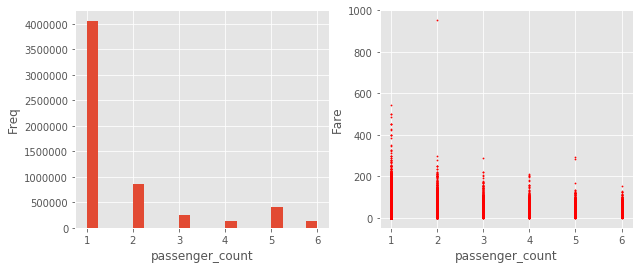

In [57]:
EDA2(df_train, "passenger_count", bins = 20) # df_train["passenger_count"].max())


From the above 2 graphs we can see that single passengers are the most frequent travellers, 

and the highest fare also seems to come from cabs which carry just 1 passenger.


### 2. X(pickup datetime) affect Y(fare) ?

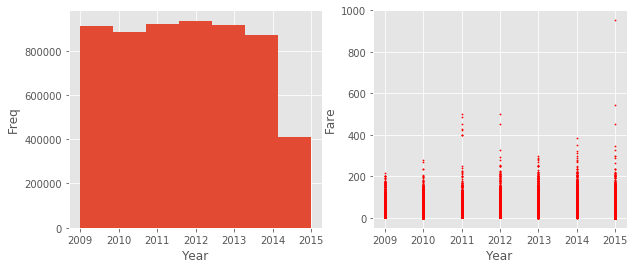

In [58]:
EDA2(df_train, "Year", bins = 7)

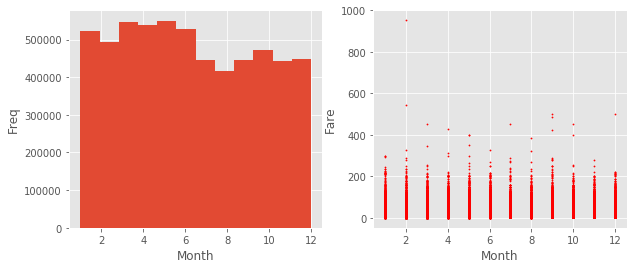

In [59]:
EDA2(df_train, "Month", bins = 12)

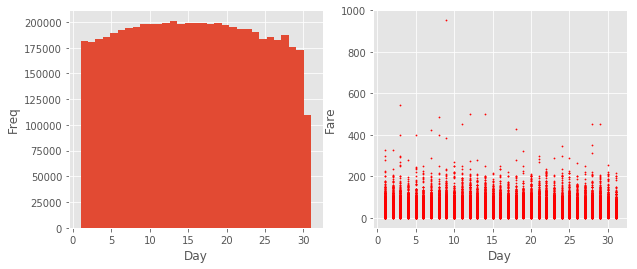

In [60]:
EDA2(df_train, "Day", bins = df_train["Day"].max() - df_train["Day"].min() + 1)

The fares throught the month mostly seem uniform, with the maximum fare received on the 12th

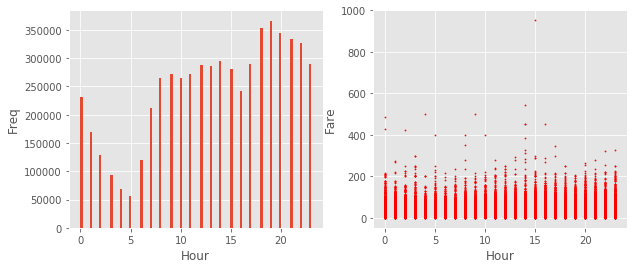

In [61]:
EDA2(df_train, "Hour", bins = 100) #df_train["Hour"].max() - df_train["Hour"].min() + 1)

Interesting! 

The time of day definitely plays an important role. 

The frequency of cab rides seem to be the lowest at 5AM and the highest at 7PM.


--


The fares, however, seem to be high betweeb 5AM and 10AM, and 2PM to 4PM. 

Maybe people who live far away prefer to leave earlier to avoid rush hour traffic?


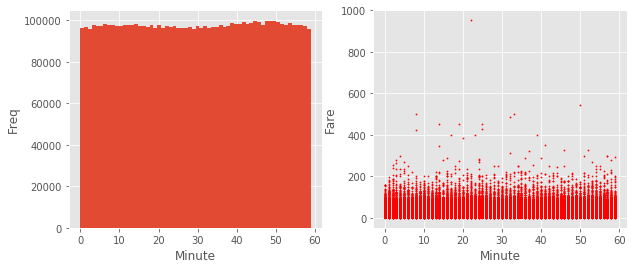

In [62]:
EDA2(df_train, "Minute", bins = df_train["Minute"].max() - df_train["Minute"].min() + 1)

### 3. Does the day of the week affect the fare?

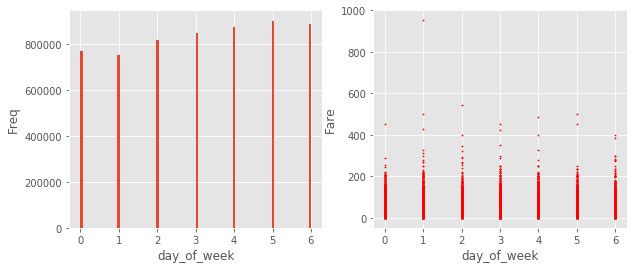

In [63]:
EDA2(df_train, "day_of_week", bins = 100)

Nah, day of the week doesn't seem to have that much of an influence on the number of cab rides

--

The highest fares seem to be on a Sunday and Monday, and the lowest on Wednesday and Friday. Maybe people travel far distances on Sunday and Monday (visiting family and returning back home), and hence, the high fares. And guess people just want to stay at home on a Friday after a hectic week at work, or grab a drink from close by. Hmmm..

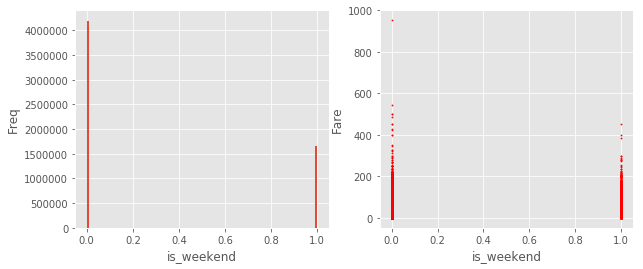

In [64]:
EDA2(df_train, "is_weekend", bins = 100)

### 4. X(distance) affect Y(fare) ?

This is a no-brainer. I am confident that the distance would affect the fare a great deal. But I will visualise it.

Firstly, let's check the frequency of the distances that we calculated using Haversine formula. I will do so by creating bins (0-10 kms, 10-20 kms, and so on, and check for any outliers)

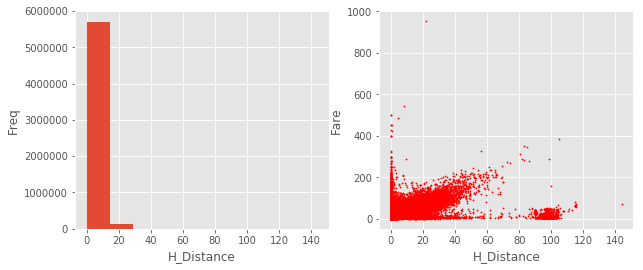

In [65]:
EDA2(df_train, "H_Distance", bins = 10)

In [66]:
bins_0 = df_train.loc[(df_train['H_Distance'] == 0), ['H_Distance']]
bins_1 = df_train.loc[(df_train['H_Distance'] > 0) & (df_train['H_Distance'] <= 10),['H_Distance']]
bins_2 = df_train.loc[(df_train['H_Distance'] > 10) & (df_train['H_Distance'] <= 50),['H_Distance']]
bins_3 = df_train.loc[(df_train['H_Distance'] > 50) & (df_train['H_Distance'] <= 100),['H_Distance']]
bins_4 = df_train.loc[(df_train['H_Distance'] > 100) & (df_train['H_Distance'] <= 200),['H_Distance']]
bins_5 = df_train.loc[(df_train['H_Distance'] > 200) & (df_train['H_Distance'] <= 300),['H_Distance']]
bins_6 = df_train.loc[(df_train['H_Distance'] > 300),['H_Distance']]
bins_0['bins'] = '0'
bins_1['bins'] = '0-10'
bins_2['bins'] = '11-50'
bins_3['bins'] = '51-100'
bins_4['bins'] = '100-200'
bins_5['bins'] = '201-300'
bins_6['bins'] = '>300'
dist_bins =pd.concat([bins_0,bins_1,bins_2,bins_3,bins_4,bins_5,bins_6])
#len(dist_bins)
dist_bins.columns

Index(['H_Distance', 'bins'], dtype='object')

In [67]:
## 畫圖畫超久卻畫不出來

# plt.figure(figsize=(15,7))
# plt.hist(dist_bins['bins'], bins=75)
# plt.xlabel('Bins')
# plt.ylabel('Frequency')

In [68]:
Counter(dist_bins['bins'])

Counter({'0': 62137,
         '0-10': 5494402,
         '11-50': 293230,
         '51-100': 785,
         '100-200': 197})

There are values which are greater than 100 kms! In NYC I am not sure why people would take cabs to travel more than a 100 kms. 

Since the number of bins for 100-200 kms is quite high, I will keep these. These outliers could be because of typos or missing values in the latitude or longitude. Remove fields of the following -

1. Pickup latitude and pickup longitude are 0 but dropoff latitude and longitude are not 0, but the fare is 0

2. vice versa of point 1.

3. Pickup latitude and pickup longitude are 0 but dropoff latitude and longitude are not 0, but the fare is NOT 0. Here I will have to impute the distance values in both the train and test data.

In [69]:
df_train.sort_values(['H_Distance','fare_amount'], ascending=False)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,Year,...,Hour,Minute,Second,day_cycle,day_of_week,week_of_year,year_cycle,week_cycle,is_weekend,H_Distance
3499639,2010-06-06 12:15:00.00000067,73.21,2010-06-06 12:15:00,-72.944747,41.595968,-74.176937,40.694677,1,2010-06-06,2010,...,12,15,0,-0.065403,0,23,-0.994522,4.338837e-01,1,143.834697
3452739,2009-05-30 06:45:59.0000001,71.30,2009-05-30 06:45:59,-73.137393,41.366138,-74.181590,40.687739,1,2009-05-30,2009,...,6,45,59,0.979939,6,21,-1.000000,-6.234898e-01,1,115.596397
4624995,2009-03-12 08:43:12.0000006,67.85,2009-03-12 08:43:12,-73.137393,41.366138,-74.181235,40.687757,2,2009-03-12,2009,...,8,43,12,0.756995,4,10,-0.207912,-6.801727e-01,0,115.572520
3484015,2009-07-17 19:22:47.0000003,59.64,2009-07-17 19:22:47,-73.137393,41.366138,-74.064165,40.598784,2,2009-07-17,2009,...,19,22,47,-0.935470,5,28,-0.681998,-8.841154e-01,0,115.465400
2338554,2010-06-19 14:32:17.0000002,60.30,2010-06-19 14:32:17,-73.137393,41.366138,-74.177279,40.691147,2,2010-06-19,2010,...,14,32,17,-0.616635,6,24,-0.945519,-3.653410e-01,1,115.073410
3068124,2009-07-05 18:12:52.0000001,63.50,2009-07-05 18:12:52,-73.137393,41.366138,-74.176947,40.691703,2,2009-07-05,2009,...,18,12,52,-0.998424,0,27,-0.819152,6.234898e-01,1,115.011702
2296216,2009-09-07 16:20:32.0000002,67.50,2009-09-07 16:20:32,-73.137393,41.366138,-74.177918,40.695327,4,2009-09-07,2009,...,16,20,32,-0.907289,1,36,0.121869,9.972038e-01,0,114.809443
5304339,2009-05-05 14:22:35.0000006,82.90,2009-05-05 14:22:35,-73.137393,41.366138,-74.177918,40.695470,2,2009-05-05,2009,...,14,22,35,-0.582773,2,18,-0.906308,7.330519e-01,0,114.799041
5252300,2010-06-19 15:08:10.0000007,62.30,2010-06-19 15:08:10,-73.137393,41.366138,-74.177918,40.695596,2,2010-06-19,2010,...,15,8,10,-0.731849,6,24,-0.945519,-3.302791e-01,1,114.789878
1632730,2009-10-11 17:15:16.0000001,59.90,2009-10-11 17:15:16,-73.137393,41.366138,-74.177445,40.695201,1,2009-10-11,2009,...,17,15,16,-0.981012,0,41,0.656059,5.938202e-01,1,114.788454


In [70]:
Counter(dist_bins['bins'])

Counter({'0': 62137,
         '0-10': 5494402,
         '11-50': 293230,
         '51-100': 785,
         '100-200': 197})

In [71]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Day,Hour,Minute,Second,day_cycle,day_of_week,week_of_year,year_cycle,week_cycle,is_weekend,H_Distance
count,5.850751e+06,5.850751e+06,5.850751e+06,5.850751e+06,5.850751e+06,5.850751e+06,5.850751e+06,5.850751e+06,5.850751e+06,5.850751e+06,5.850751e+06,5.850751e+06,5.850751e+06,5.850751e+06,5.850751e+06,5.850751e+06,5.850751e+06,5.850751e+06,5.850751e+06
mean,1.132773e+01,-7.397516e+01,4.075109e+01,-7.397430e+01,4.075147e+01,1.690381e+00,2.011738e+03,6.269353e+00,1.571739e+01,1.351115e+01,2.957279e+01,1.581652e+01,-2.047360e-01,3.122326e+00,2.509590e+01,-2.948691e-02,-5.362349e-02,2.830343e-01,3.327872e+00
std,9.688888e+00,3.838611e-02,2.949281e-02,3.753549e-02,3.270861e-02,1.305966e+00,1.865850e+00,3.436012e+00,8.686034e+00,6.515159e+00,1.732862e+01,1.942863e+01,6.521403e-01,1.987809e+00,1.498187e+01,7.094331e-01,7.025284e-01,4.504730e-01,3.770117e+00
min,0.000000e+00,-7.449650e+01,4.050005e+01,-7.449991e+01,4.050005e+01,1.000000e+00,2.009000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,-7.399228e+01,4.073657e+01,-7.399158e+01,4.073561e+01,1.000000e+00,2.010000e+03,3.000000e+00,8.000000e+00,9.000000e+00,1.500000e+01,0.000000e+00,-8.174801e-01,1.000000e+00,1.200000e+01,-7.431448e-01,-7.818315e-01,0.000000e+00,1.253493e+00
50%,8.500000e+00,-7.398210e+01,4.075335e+01,-7.398061e+01,4.075387e+01,1.000000e+00,2.012000e+03,6.000000e+00,1.600000e+01,1.400000e+01,3.000000e+01,4.000000e+00,-3.386011e-01,3.000000e+00,2.400000e+01,-5.233596e-02,-1.119645e-01,0.000000e+00,2.152283e+00
75%,1.250000e+01,-7.396833e+01,4.076754e+01,-7.396536e+01,4.076841e+01,2.000000e+00,2.013000e+03,9.000000e+00,2.300000e+01,1.900000e+01,4.500000e+01,3.200000e+01,3.624380e-01,5.000000e+00,3.800000e+01,6.819984e-01,6.234898e-01,1.000000e+00,3.909911e+00
max,9.520000e+02,-7.281258e+01,4.169685e+01,-7.281783e+01,4.171463e+01,6.000000e+00,2.015000e+03,1.200000e+01,3.100000e+01,2.300000e+01,5.900000e+01,5.900000e+01,1.000000e+00,6.000000e+00,5.300000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.438347e+02


In [72]:
df_train[["fare_amount", "H_Distance"]].describe()

,fare_amount,H_Distance
count,5.850751e+06,5.850751e+06
mean,1.132773e+01,3.327872e+00
std,9.688888e+00,3.770117e+00
min,0.000000e+00,0.000000e+00
25%,6.000000e+00,1.253493e+00
50%,8.500000e+00,2.152283e+00
75%,1.250000e+01,3.909911e+00
max,9.520000e+02,1.438347e+02


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021CCA570BE0>,
      dtype=object)

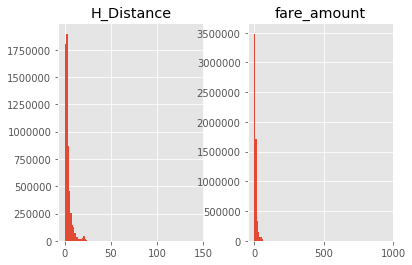

In [73]:
df_train[["fare_amount", "H_Distance"]].hist(bins=100)

### case 1. Pickup latitude and pickup longitude are 0 but dropoff latitude and longitude are not 0, but the fare is 0

亦即，Distance != 0, but Fare == 0

In [74]:
df_train.shape

(5850751, 22)

In [75]:
df_train.loc[((df_train['pickup_latitude']==0) & (df_train['pickup_longitude']==0)) & 
             ((df_train['dropoff_latitude']!=0) & (df_train['dropoff_longitude']!=0)) & 
             (df_train['fare_amount']==0)
            ]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,Year,...,Hour,Minute,Second,day_cycle,day_of_week,week_of_year,year_cycle,week_cycle,is_weekend,H_Distance


In [76]:
# Distance != 0, but Fare == 0

# pickup latitude and longitude = 0
df_train = df_train.drop(df_train.loc[((df_train['pickup_latitude']==0) & (df_train['pickup_longitude']==0)) & 
                                      ((df_train['dropoff_latitude']!=0) & (df_train['dropoff_longitude']!=0)) & 
                                      (df_train['fare_amount']==0)
                                     ].index, axis=0)
df_train.shape

(5850751, 22)

### case 2. Dropoff latitude and pickup longitude are 0 but pickup latitude and longitude are not 0, but the fare is 0

亦即，還是 Distance != 0, but Fare == 0

In [77]:
df_train.loc[((df_train['pickup_latitude']!=0) & (df_train['pickup_longitude']!=0)) & 
             ((df_train['dropoff_latitude']==0) & (df_train['dropoff_longitude']==0)) & 
             (df_train['fare_amount']==0)
            ]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,Year,...,Hour,Minute,Second,day_cycle,day_of_week,week_of_year,year_cycle,week_cycle,is_weekend,H_Distance


In [78]:
# Distance != 0, but Fare == 0

# dropoff latitude and longitude = 0
df_train = df_train.drop(df_train.loc[((df_train['pickup_latitude']!=0) & (df_train['pickup_longitude']!=0)) & 
                                      ((df_train['dropoff_latitude']==0) & (df_train['dropoff_longitude']==0)) & 
                                      (df_train['fare_amount']==0)
                                     ].index, axis=0)
df_train.shape

(5850751, 22)

剛剛純粹先用X(經緯度)跟Y(fare)一起看，希望找出不合理的 : ex. Distance != 0, but Fare == 0


現在直接用X(distance)跟Y(fare)一起看

先看H_Distance為大的極端值

Check the H_Distance fields which are greater than 200 kms 

cause there is no way that people would travel more than 200 kms at the most in NYC in a CAB!

In [84]:
high_distance = df_train.loc[(df_train['H_Distance']>200) & (df_train['fare_amount']!=0)]
print(high_distance.shape)
high_distance.head()

(0, 22)


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,Year,...,Hour,Minute,Second,day_cycle,day_of_week,week_of_year,year_cycle,week_cycle,is_weekend,H_Distance


既然這些大到不合理的distance資料有fare，就用fare來回填比較正確的distance

但是因為先清掉水中不合理的數據，導致現在沒有high_distance(H_Distance>200且fare_amount!=0)的資料，

就先把這段註解掉吧

In [88]:
# high_distance['H_Distance'] = high_distance.apply(lambda row: (row['fare_amount'] - 2.50) / 1.56, axis=1)

In [89]:
# #sync the train data with the newly computed distance values from high_distance dataframe
# df_train.update(high_distance)

再看H_Distance為小的極端值

In [90]:
df_train[df_train['H_Distance']==0]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,Year,...,Hour,Minute,Second,day_cycle,day_of_week,week_of_year,year_cycle,week_cycle,is_weekend,H_Distance
105,2009-03-25 00:08:52.0000001,52.00,2009-03-25 00:08:52,-74.035839,40.747320,-74.035839,40.747320,1,2009-03-25,2009,...,0,8,52,0.038678,3,12,-0.422618,4.338837e-01,0,0.0
191,2014-01-08 21:55:58.0000006,6.50,2014-01-08 21:55:58,-73.998488,40.726303,-73.998488,40.726303,1,2014-01-08,2014,...,21,55,58,-0.515163,3,1,0.788011,-3.302791e-01,0,0.0
270,2012-08-25 01:53:42.0000005,7.50,2012-08-25 01:53:42,-73.995892,40.746454,-73.995892,40.746454,1,2012-08-25,2012,...,1,53,42,0.476008,6,34,-0.087156,-7.579717e-01,1,0.0
290,2009-12-14 12:33:00.00000075,6.90,2009-12-14 12:33:00,-73.982432,40.745747,-73.982432,40.745747,1,2009-12-14,2009,...,12,33,0,-0.143493,1,50,0.970296,9.749279e-01,0,0.0
396,2014-03-12 18:12:44.0000006,12.00,2014-03-12 18:12:44,-73.844904,40.736318,-73.844904,40.736318,1,2014-03-12,2014,...,18,12,44,-0.998457,3,10,-0.207912,-2.225209e-01,0,0.0
503,2010-01-19 01:10:00.00000012,2.50,2010-01-19 01:10:00,-73.998720,40.624708,-73.998720,40.624708,1,2010-01-19,2010,...,1,10,0,0.300706,2,3,0.656059,9.659258e-01,0,0.0
657,2009-08-25 01:50:21.0000001,2.50,2009-08-25 01:50:21,-73.986410,40.763350,-73.986410,40.763350,1,2009-08-25,2009,...,1,50,21,0.463103,2,34,-0.087156,9.659258e-01,0,0.0
737,2014-08-11 19:37:00.000000174,57.33,2014-08-11 19:37:00,-73.776477,40.646290,-73.776477,40.646290,2,2014-08-11,2014,...,19,37,0,-0.911762,1,32,-0.325568,9.993007e-01,0,0.0
808,2010-10-22 02:24:53.0000001,6.10,2010-10-22 02:24:53,-73.984433,40.771084,-73.984433,40.771084,1,2010-10-22,2010,...,2,24,53,0.590899,5,42,0.788011,-9.888308e-01,0,0.0
843,2014-07-19 04:42:00.00000041,5.50,2014-07-19 04:42:00,-73.990532,40.719085,-73.990532,40.719085,1,2014-07-19,2014,...,4,42,0,0.942641,6,28,-0.656059,-6.801727e-01,1,0.0


We can see a few rows with distance =0. This could be due to 2 reasons

1. The cab waited the whole time and the passenger eventually cancelled. That's why the pickup and drop co-ordinates are the same and maybe, the passenger was charged for the waiting time.

2. The pickup and drop co-ordinates were not entered. In other words, these are missing values!


28667 rows are too many rows to be deleted. We need to impute these missing values. I have a plan. I intend to impute the missing distance values with the fare and average price per kilometer of NYC cabs.

A quick Google search gave me the following prices -

> $$2.5 base-price + $1.56/km --> 6AM to 8PM Mon-Fri

> $$3.0 base-price + $1.56/km --> 8PM to 6AM Mon-Fri and Sat&Sun

However, before we proceed with the above steps, lets check for the following scenarios to impute the missing fare amount and the H_Distance in train data.

### SCENARIO 1

Fare and Distance are both 0. According to the table above, we shall delete them as they do not provide us any info with regards to the data.

> Fare == 0 and Distance == 0 --- 刪除

### SCENARIO 2

Fare is not 0 and is less than the base amount, but Distance is 0.

Delete these rows as the minimum is $2.50, and these fares are incorrect values.

> Fare != 0, Fare < base, and Distance == 0 --- 刪除

### SCENARIO 3

Fare is 0, but Distance is not 0. These values need to be imputed.

I can calculate the fare as I have the distance. I shall use the following formula

>　fare = 2.5 + 1.56(H_Distance)

> Fare == 0 and Distance != 0 --- impute : 用 distance 回填 fare


### SCENARIO 4

Fare is not 0, but Distance is 0. These values need to be imputed.

> Fare != 0 and Distance == 0 --- impute : 用 fare 回填 distance

In [91]:
df_train.shape

(5850751, 22)

SCENARIO 1

> Fare == 0 and Distance == 0 --- 刪除

In [92]:
df_train[(df_train['H_Distance']==0)&(df_train['fare_amount']==0)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,Year,...,Hour,Minute,Second,day_cycle,day_of_week,week_of_year,year_cycle,week_cycle,is_weekend,H_Distance
331597,2013-08-05 06:45:54.0000005,0.0,2013-08-05 06:45:54,-73.982354,40.679971,-73.982354,40.679971,1,2013-08-05,2013,...,6,45,54,0.980012,1,31,-0.422618,0.900969,0,0.0
436658,2015-03-04 22:33:39.0000008,0.0,2015-03-04 22:33:39,-74.043442,40.788208,-74.043442,40.788208,1,2015-03-04,2015,...,22,33,39,-0.367922,3,9,-0.069756,-0.365341,0,0.0
689250,2015-05-27 23:10:03.0000004,0.0,2015-05-27 23:10:03,-73.994125,40.741131,-73.994125,40.741131,1,2015-05-27,2015,...,23,10,3,-0.216227,3,21,-0.998630,-0.399892,0,0.0
1662545,2010-03-13 02:39:29.0000001,0.0,2010-03-13 02:39:29,-74.035278,40.738683,-74.035278,40.738683,2,2010-03-13,2010,...,2,39,29,0.641059,6,10,-0.224951,-0.733052,1,0.0
2214498,2010-02-03 11:44:07.0000002,0.0,2010-02-03 11:44:07,-74.014147,40.710546,-74.014147,40.710546,1,2010-02-03,2010,...,11,44,7,0.069249,3,5,0.453990,0.037391,0,0.0
2329503,2015-02-19 09:43:11.0000007,0.0,2015-02-19 09:43:11,-73.953857,40.813251,-73.953857,40.813251,1,2015-02-19,2015,...,9,43,11,0.562144,4,7,0.190809,-0.707107,0,0.0
2581417,2015-05-07 19:12:43.0000005,0.0,2015-05-07 19:12:43,-73.913727,40.779018,-73.913727,40.779018,1,2015-05-07,2015,...,19,12,43,-0.950086,4,18,-0.920505,-0.916562,0,0.0
3070651,2015-01-25 20:54:02.0000004,0.0,2015-01-25 20:54:02,-73.981293,40.769012,-73.981293,40.769012,1,2015-01-25,2015,...,20,54,2,-0.725274,0,4,0.573576,0.680173,1,0.0
3252539,2015-01-14 10:15:51.0000002,0.0,2015-01-14 10:15:51,-73.937508,40.758129,-73.937508,40.758129,1,2015-01-14,2015,...,10,15,51,0.438959,3,2,0.719340,0.074730,0,0.0
3712453,2010-03-29 12:47:22.0000005,0.0,2010-03-29 12:47:22,-73.836776,40.869879,-73.836776,40.869879,1,2010-03-29,2010,...,12,47,22,-0.205208,1,13,-0.484810,0.974928,0,0.0


In [93]:
df_train = df_train.drop(df_train[(df_train['H_Distance']==0) & 
                                  (df_train['fare_amount']==0)
                                 ].index, axis = 0)
df_train.shape

(5850735, 22)

SCENARIO 2

> Fare != 0, Fare < base, and Distance == 0 --- 刪除

### base 依照平日尖峰 平日離峰 假日 的不同而有不同公式

In [94]:
#Between 6AM and 8PM on Mon-Fri
rush_hour = df_train.loc[(((df_train['Hour']>=6)&(df_train['Hour']<=20)) & 
                       ((df_train['day_of_week']>=1) & (df_train['day_of_week']<=5)) & 
                       (df_train['H_Distance']==0) & 
                       (df_train['fare_amount'] < 2.5))
                     ]
rush_hour

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,Year,...,Hour,Minute,Second,day_cycle,day_of_week,week_of_year,year_cycle,week_cycle,is_weekend,H_Distance
1215355,2015-05-29 18:15:27.0000006,2.00,2015-05-29 18:15:27,-73.903214,40.747318,-73.903214,40.747318,1,2015-05-29,2015,...,18,15,27,-0.997729,5,21,-0.999848,-0.900969,0,0.0
2322071,2010-02-25 12:44:00.000000125,1.25,2010-02-25 12:44:00,-73.937722,40.758318,-73.937722,40.758318,5,2010-02-25,2010,...,12,44,0,-0.190809,4,8,0.087156,-0.781831,0,0.0
4112515,2015-04-15 20:12:10.0000005,0.01,2015-04-15 20:12:10,-73.994553,40.750240,-73.994553,40.750240,1,2015-04-15,2015,...,20,12,10,-0.838274,3,15,-0.707107,-0.294755,0,0.0
5425695,2015-02-05 17:02:10.0000007,0.01,2015-02-05 17:02:10,-73.866501,40.770050,-73.866501,40.770050,1,2015-02-05,2015,...,17,2,10,-0.968329,4,5,0.422618,-0.884115,0,0.0


In [95]:
df_train=df_train.drop(rush_hour.index, axis=0)
df_train.shape

(5850731, 22)

In [96]:
#Between 8PM and 6AM on Mon-Fri
non_rush_hour = df_train.loc[((df_train['Hour']<6)|(df_train['Hour']>20)) & 
                             ((df_train['day_of_week']>=1)&(df_train['day_of_week']<=5)) & 
                             (df_train['H_Distance']==0) & 
                             (df_train['fare_amount'] < 3.0)
                            ]
#print(Counter(non_work_hours['Hour']))
#print(Counter(non_work_hours['day_of_week']))
print(Counter(non_rush_hour['fare_amount']))
non_rush_hour

# 但觀察後決定保留，因為雖然<該時段的base(3元)，卻沒有小於最基本的2.5元
#keep these. Since the fare_amount is not <2.5 (which is the base fare), these values seem legit to me.

Counter({2.5: 774, 2.9: 71, 1.0: 1, 0.01: 1})


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,Year,...,Hour,Minute,Second,day_cycle,day_of_week,week_of_year,year_cycle,week_cycle,is_weekend,H_Distance
503,2010-01-19 01:10:00.00000012,2.5,2010-01-19 01:10:00,-73.998720,40.624708,-73.998720,40.624708,1,2010-01-19,2010,...,1,10,0,0.300706,2,3,0.656059,0.965926,0,0.0
657,2009-08-25 01:50:21.0000001,2.5,2009-08-25 01:50:21,-73.986410,40.763350,-73.986410,40.763350,1,2009-08-25,2009,...,1,50,21,0.463103,2,34,-0.087156,0.965926,0,0.0
16074,2013-05-30 00:19:40.0000001,2.5,2013-05-30 00:19:40,-73.782520,40.644488,-73.782520,40.644488,1,2013-05-30,2013,...,0,19,40,0.085707,4,21,-1.000000,-0.433884,0,0.0
18037,2009-01-07 22:16:00.000000172,2.5,2009-01-07 22:16:00,-73.992220,40.759068,-73.992220,40.759068,2,2009-01-07,2009,...,22,16,0,-0.438371,3,1,0.798636,-0.365341,0,0.0
24835,2015-02-27 02:23:09.0000004,2.5,2015-02-27 02:23:09,-73.983330,40.738205,-73.983330,40.738205,1,2015-02-27,2015,...,2,23,9,0.584781,5,8,0.052336,-0.988831,0,0.0
29613,2009-06-17 03:14:11.0000001,2.5,2009-06-17 03:14:11,-73.934842,40.740996,-73.934842,40.740996,1,2009-06-17,2009,...,3,14,11,0.749486,3,24,-0.956305,0.330279,0,0.0
47234,2012-10-10 22:12:08.0000003,2.5,2012-10-10 22:12:08,-73.999537,40.758855,-73.999537,40.758855,1,2012-10-10,2012,...,22,12,8,-0.453472,3,41,0.642788,-0.365341,0,0.0
48454,2015-06-18 21:51:07.0000004,2.5,2015-06-18 21:51:07,-73.776413,40.646133,-73.776413,40.646133,1,2015-06-18,2015,...,21,51,7,-0.533184,4,24,-0.951057,-0.943883,0,0.0
53409,2009-09-18 23:19:51.0000004,2.5,2009-09-18 23:19:51,-73.973521,40.754659,-73.973521,40.754659,1,2009-09-18,2009,...,23,19,51,-0.174293,5,37,0.309017,-0.804598,0,0.0
54273,2013-08-20 22:14:44.0000003,2.5,2013-08-20 22:14:44,-73.968369,40.762157,-73.968369,40.762157,1,2013-08-20,2013,...,22,14,44,-0.443332,2,33,-0.173648,0.500000,0,0.0


In [97]:
#Saturday and Sunday all hours
weekends = df_train.loc[((df_train['day_of_week']==0) | (df_train['day_of_week']==6)) & 
                        (df_train['H_Distance']==0) & 
                        (df_train['fare_amount'] < 3.0)
                       ]


print(Counter(weekends['fare_amount']))
#Counter(weekends['day_of_week'])
weekends

# 但觀察後決定保留，因為雖然<該時段的base(3元)，卻沒有小於最基本的2.5元
#keep these too. Since the fare_amount is not <2.5, these values seem legit to me.

Counter({2.5: 1238, 2.9: 127, 2.94: 1, 2.0: 1})


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,Year,...,Hour,Minute,Second,day_cycle,day_of_week,week_of_year,year_cycle,week_cycle,is_weekend,H_Distance
1419,2013-07-21 00:10:23.0000001,2.5,2013-07-21 00:10:23,-73.956556,40.779828,-73.956556,40.779828,1,2013-07-21,2013,...,0,10,23,0.045290,0,29,-0.629320,0.000000,1,0.0
4954,2010-01-10 13:44:35.0000007,2.5,2010-01-10 13:44:35,-73.983934,40.754938,-73.983934,40.754938,1,2010-01-10,2010,...,13,44,35,-0.440657,0,2,0.766044,0.467269,1,0.0
5449,2010-07-17 06:24:04.0000002,2.5,2010-07-17 06:24:04,-73.934094,40.751906,-73.934094,40.751906,1,2010-07-17,2010,...,6,24,4,0.994491,6,28,-0.681998,-0.623490,1,0.0
11593,2010-10-17 04:28:00.00000015,2.9,2010-10-17 04:28:00,-73.851972,40.679820,-73.851972,40.679820,5,2010-10-17,2010,...,4,28,0,0.920505,0,42,0.731354,0.149042,1,0.0
14763,2009-11-07 14:29:14.0000003,2.9,2009-11-07 14:29:14,-73.965505,40.806097,-73.965505,40.806097,1,2009-11-07,2009,...,14,29,14,-0.606104,6,44,0.920505,-0.365341,1,0.0
21427,2011-08-21 12:28:36.0000004,2.5,2011-08-21 12:28:36,-73.948750,40.744915,-73.948750,40.744915,1,2011-08-21,2011,...,12,28,36,-0.124467,0,34,-0.156434,0.433884,1,0.0
31587,2014-09-13 13:52:04.0000004,2.5,2014-09-13 13:52:04,-73.782361,40.644350,-73.782361,40.644350,1,2014-09-13,2014,...,13,52,4,-0.469728,6,36,0.224951,-0.399892,1,0.0
33762,2013-12-07 11:34:46.0000005,2.5,2013-12-07 11:34:46,-73.995682,40.761174,-73.995682,40.761174,1,2013-12-07,2013,...,11,34,46,0.109879,6,48,0.992546,-0.467269,1,0.0
33815,2009-12-06 00:00:00.0000009,2.9,2009-12-06 00:00:00,-73.988572,40.737603,-73.988572,40.737603,1,2009-12-06,2009,...,0,0,0,0.000000,0,49,0.994522,0.000000,1,0.0
38887,2011-09-03 01:43:00.000000145,2.9,2011-09-03 01:43:00,-73.964000,40.761310,-73.964000,40.761310,3,2011-09-03,2011,...,1,43,0,0.434445,6,35,0.052336,-0.757972,1,0.0


From scenario 2, I can understand that the distance is 0, but the fare is all the minimum fare of $2.5. 

This could be because the passenger booked the cab but ended up cancelling to pay the base fare 

(not sure how this works in NYC, but I'm assuming that's how it is)

SCENARIO 3

> Fare == 0 and Distance != 0 --- impute : 用 distance 回填 fare

> fare = 2.5 + 1.56(H_Distance)

In [98]:
df_train.loc[(df_train['H_Distance']!=0) & (df_train['fare_amount']==0)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,Year,...,Hour,Minute,Second,day_cycle,day_of_week,week_of_year,year_cycle,week_cycle,is_weekend,H_Distance
10002,2010-02-15 14:26:01.0000003,0.0,2010-02-15 14:26:01,-73.987115,40.738808,-74.005911,40.713960,1,2010-02-15,2010,...,14,26,1,-0.594881,1,7,2.588190e-01,9.888308e-01,0,3.184763
27891,2015-05-15 21:40:28.00000010,0.0,2015-05-15 21:40:28,-74.077927,40.805714,-74.077919,40.805721,1,2015-05-15,2015,...,21,40,28,-0.571907,5,19,-9.659258e-01,-8.467242e-01,0,0.001064
47302,2010-03-18 19:13:39.0000002,0.0,2010-03-18 19:13:39,-73.942346,40.806269,-73.942463,40.806129,1,2010-03-18,2010,...,19,13,39,-0.948807,4,11,-3.090170e-01,-9.165623e-01,0,0.018420
175352,2014-06-29 16:04:29.0000002,0.0,2014-06-29 16:04:29,-73.484480,40.813401,-73.484442,40.813323,2,2014-06-29,2014,...,16,4,29,-0.875640,0,26,-8.746197e-01,5.633201e-01,1,0.009244
211455,2015-04-15 14:02:39.0000003,0.0,2015-04-15 14:02:39,-73.937378,40.758450,-73.937447,40.758450,1,2015-04-15,2015,...,14,2,39,-0.509980,3,15,-7.071068e-01,-7.473009e-02,0,0.005783
211499,2010-03-08 18:22:00.00000076,0.0,2010-03-08 18:22:00,-73.937353,40.758227,-73.937358,40.758230,1,2010-03-08,2010,...,18,22,0,-0.995396,1,10,-1.391731e-01,1.000000e+00,0,0.000537
266485,2010-02-20 09:51:27.0000004,0.0,2010-02-20 09:51:27,-73.877376,40.772415,-73.877403,40.772391,1,2010-02-20,2010,...,9,51,27,0.531953,6,7,1.736482e-01,-5.320321e-01,1,0.003506
386734,2015-05-08 07:02:38.0000001,0.0,2015-05-08 07:02:38,-73.999496,40.748787,-74.002556,40.744659,1,2015-05-08,2015,...,7,2,38,0.962888,5,18,-9.271839e-01,-9.993007e-01,0,0.526370
431819,2015-01-13 00:48:21.0000001,0.0,2015-01-13 00:48:21,-73.998383,40.759418,-74.031189,40.748924,1,2015-01-13,2015,...,0,48,21,0.209405,2,2,7.313537e-01,9.749279e-01,0,2.999630
489767,2015-02-14 21:06:53.0000007,0.0,2015-02-14 21:06:53,-73.949951,40.776215,-73.949959,40.776218,2,2015-02-14,2015,...,21,6,53,-0.685554,6,6,2.756374e-01,-1.119645e-01,1,0.000770


In [99]:
scenario_3 = df_train.loc[(df_train['H_Distance']!=0) & (df_train['fare_amount']==0)]

# Check if We do """NOT""" have any distance values that are outliers.
scenario_3.sort_values('H_Distance', ascending=False)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,Year,...,Hour,Minute,Second,day_cycle,day_of_week,week_of_year,year_cycle,week_cycle,is_weekend,H_Distance
3614406,2015-05-12 08:28:24.0000003,0.0,2015-05-12 08:28:24,-73.820679,40.665684,-74.181442,40.687679,1,2015-05-12,2015,...,8,28,24,0.797584,2,19,-0.951057,8.660254e-01,0,30.521392
5619540,2015-05-06 02:30:08.0000003,0.0,2015-05-06 02:30:08,-73.991905,40.750172,-73.646988,40.747463,1,2015-05-06,2015,...,2,30,8,0.609223,3,18,-0.913545,3.653410e-01,0,29.056989
5867720,2015-05-06 23:31:49.0000003,0.0,2015-05-06 23:31:49,-73.981064,40.762581,-74.307541,40.789238,1,2015-05-06,2015,...,23,31,49,-0.122663,3,18,-0.913545,-3.998920e-01,0,27.650176
5325349,2015-02-07 01:58:09.0000006,0.0,2015-02-07 01:58:09,-74.009926,40.736710,-74.282852,40.614143,3,2015-02-07,2015,...,1,58,9,0.492993,6,5,0.390731,-7.579717e-01,1,26.748730
1107618,2015-05-31 01:52:15.0000002,0.0,2015-05-31 01:52:15,-73.997482,40.758915,-74.144936,40.946930,4,2015-05-31,2015,...,1,52,15,0.470434,0,22,-0.999848,3.739119e-02,1,24.308001
3763201,2010-03-05 21:43:42.0000002,0.0,2010-03-05 21:43:42,-73.786049,40.641929,-73.981236,40.782779,4,2010-03-05,2010,...,21,43,42,-0.560278,5,9,-0.087156,-8.467242e-01,0,22.714278
5529748,2015-01-14 12:06:52.0000006,0.0,2015-01-14 12:06:52,-73.786140,40.642101,-73.986061,40.759823,2,2015-01-14,2015,...,12,6,52,-0.029957,3,2,0.719340,1.224647e-16,0,21.339617
1902135,2010-03-08 20:23:36.0000002,0.0,2010-03-08 20:23:36,-73.786727,40.640482,-73.979946,40.762910,5,2010-03-08,2010,...,20,23,36,-0.810042,1,10,-0.139173,9.972038e-01,0,21.227931
1614540,2010-03-15 08:10:44.0000001,0.0,2010-03-15 08:10:44,-73.781774,40.644808,-73.955025,40.773615,1,2010-03-15,2010,...,8,10,44,0.841668,1,11,-0.258819,9.308737e-01,0,20.454613
3293887,2015-03-22 00:58:52.0000005,0.0,2015-03-22 00:58:52,-73.940399,40.788902,-73.941391,40.627312,4,2015-03-22,2015,...,0,58,52,0.254039,0,12,-0.374607,0.000000e+00,1,17.968247


In [100]:
# 確定沒有極端值之後才能用他來填補

scenario_3['fare_amount'] = scenario_3.apply(lambda row: ((row['H_Distance'] * 1.56) + 2.50), axis=1)
df_train.update(scenario_3)
df_train.shape

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(5850731, 22)

SCENARIO 4

> Fare != 0 and Distance == 0 --- impute : 用 fare 回填 distance

In [101]:
df_train.loc[(df_train['H_Distance']==0) & (df_train['fare_amount']!=0)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,Year,...,Hour,Minute,Second,day_cycle,day_of_week,week_of_year,year_cycle,week_cycle,is_weekend,H_Distance
105,2009-03-25 00:08:52.0000001,52.00,2009-03-25 00:08:52,-74.035839,40.747320,-74.035839,40.747320,1.0,2009-03-25,2009.0,...,0.0,8.0,52.0,0.038678,3.0,12.0,-0.422618,4.338837e-01,0.0,0.0
191,2014-01-08 21:55:58.0000006,6.50,2014-01-08 21:55:58,-73.998488,40.726303,-73.998488,40.726303,1.0,2014-01-08,2014.0,...,21.0,55.0,58.0,-0.515163,3.0,1.0,0.788011,-3.302791e-01,0.0,0.0
270,2012-08-25 01:53:42.0000005,7.50,2012-08-25 01:53:42,-73.995892,40.746454,-73.995892,40.746454,1.0,2012-08-25,2012.0,...,1.0,53.0,42.0,0.476008,6.0,34.0,-0.087156,-7.579717e-01,1.0,0.0
290,2009-12-14 12:33:00.00000075,6.90,2009-12-14 12:33:00,-73.982432,40.745747,-73.982432,40.745747,1.0,2009-12-14,2009.0,...,12.0,33.0,0.0,-0.143493,1.0,50.0,0.970296,9.749279e-01,0.0,0.0
396,2014-03-12 18:12:44.0000006,12.00,2014-03-12 18:12:44,-73.844904,40.736318,-73.844904,40.736318,1.0,2014-03-12,2014.0,...,18.0,12.0,44.0,-0.998457,3.0,10.0,-0.207912,-2.225209e-01,0.0,0.0
503,2010-01-19 01:10:00.00000012,2.50,2010-01-19 01:10:00,-73.998720,40.624708,-73.998720,40.624708,1.0,2010-01-19,2010.0,...,1.0,10.0,0.0,0.300706,2.0,3.0,0.656059,9.659258e-01,0.0,0.0
657,2009-08-25 01:50:21.0000001,2.50,2009-08-25 01:50:21,-73.986410,40.763350,-73.986410,40.763350,1.0,2009-08-25,2009.0,...,1.0,50.0,21.0,0.463103,2.0,34.0,-0.087156,9.659258e-01,0.0,0.0
737,2014-08-11 19:37:00.000000174,57.33,2014-08-11 19:37:00,-73.776477,40.646290,-73.776477,40.646290,2.0,2014-08-11,2014.0,...,19.0,37.0,0.0,-0.911762,1.0,32.0,-0.325568,9.993007e-01,0.0,0.0
808,2010-10-22 02:24:53.0000001,6.10,2010-10-22 02:24:53,-73.984433,40.771084,-73.984433,40.771084,1.0,2010-10-22,2010.0,...,2.0,24.0,53.0,0.590899,5.0,42.0,0.788011,-9.888308e-01,0.0,0.0
843,2014-07-19 04:42:00.00000041,5.50,2014-07-19 04:42:00,-73.990532,40.719085,-73.990532,40.719085,1.0,2014-07-19,2014.0,...,4.0,42.0,0.0,0.942641,6.0,28.0,-0.656059,-6.801727e-01,1.0,0.0


In [102]:
scenario_4 = df_train.loc[(df_train['H_Distance']==0) & (df_train['fare_amount']!=0)]

In [103]:
# 這些小於該時段基本費用3元的row，並沒有小於最基本費2.5 : 前面說過，這有可能是乘客臨時取消所以仍被收費，這些不impute


#Using our prior knowledge about the base price during weekdays and weekends for the cabs.
#I do not want to impute these 1502 values as they are legible ones.
scenario_4.loc[(scenario_4['fare_amount']<=3.0)&(scenario_4['H_Distance']==0)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,Year,...,Hour,Minute,Second,day_cycle,day_of_week,week_of_year,year_cycle,week_cycle,is_weekend,H_Distance
503,2010-01-19 01:10:00.00000012,2.5,2010-01-19 01:10:00,-73.998720,40.624708,-73.998720,40.624708,1.0,2010-01-19,2010.0,...,1.0,10.0,0.0,0.300706,2.0,3.0,0.656059,9.659258e-01,0.0,0.0
657,2009-08-25 01:50:21.0000001,2.5,2009-08-25 01:50:21,-73.986410,40.763350,-73.986410,40.763350,1.0,2009-08-25,2009.0,...,1.0,50.0,21.0,0.463103,2.0,34.0,-0.087156,9.659258e-01,0.0,0.0
1419,2013-07-21 00:10:23.0000001,2.5,2013-07-21 00:10:23,-73.956556,40.779828,-73.956556,40.779828,1.0,2013-07-21,2013.0,...,0.0,10.0,23.0,0.045290,0.0,29.0,-0.629320,0.000000e+00,1.0,0.0
1774,2012-08-27 15:24:00.0000007,2.5,2012-08-27 15:24:00,-73.950282,40.701282,-73.950282,40.701282,1.0,2012-08-27,2012.0,...,15.0,24.0,0.0,-0.777146,1.0,35.0,-0.052336,9.937122e-01,0.0,0.0
4367,2014-01-13 16:14:48.0000001,2.5,2014-01-13 16:14:48,-73.948410,40.744969,-73.948410,40.744969,1.0,2014-01-13,2014.0,...,16.0,14.0,48.0,-0.896486,1.0,2.0,0.731354,9.972038e-01,0.0,0.0
4954,2010-01-10 13:44:35.0000007,2.5,2010-01-10 13:44:35,-73.983934,40.754938,-73.983934,40.754938,1.0,2010-01-10,2010.0,...,13.0,44.0,35.0,-0.440657,0.0,2.0,0.766044,4.672686e-01,1.0,0.0
5449,2010-07-17 06:24:04.0000002,2.5,2010-07-17 06:24:04,-73.934094,40.751906,-73.934094,40.751906,1.0,2010-07-17,2010.0,...,6.0,24.0,4.0,0.994491,6.0,28.0,-0.681998,-6.234898e-01,1.0,0.0
6632,2010-07-28 17:37:49.0000001,2.5,2010-07-28 17:37:49,-74.001027,40.727612,-74.001027,40.727612,1.0,2010-07-28,2010.0,...,17.0,37.0,49.0,-0.995319,3.0,30.0,-0.529919,-1.859116e-01,0.0,0.0
7097,2011-03-17 11:07:00.00000030,2.9,2011-03-17 11:07:00,-74.001597,40.739490,-74.001597,40.739490,1.0,2011-03-17,2011.0,...,11.0,7.0,0.0,0.229200,4.0,11.0,-0.292372,-7.579717e-01,0.0,0.0
7408,2011-01-18 16:07:22.0000001,2.5,2011-01-18 16:07:22,-73.960443,40.761375,-73.960443,40.761375,1.0,2011-01-18,2011.0,...,16.0,7.0,22.0,-0.881647,2.0,3.0,0.669131,6.801727e-01,0.0,0.0


In [104]:
scenario_4.loc[(scenario_4['fare_amount']>3.0)&(scenario_4['H_Distance']==0)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,Year,...,Hour,Minute,Second,day_cycle,day_of_week,week_of_year,year_cycle,week_cycle,is_weekend,H_Distance
105,2009-03-25 00:08:52.0000001,52.00,2009-03-25 00:08:52,-74.035839,40.747320,-74.035839,40.747320,1.0,2009-03-25,2009.0,...,0.0,8.0,52.0,0.038678,3.0,12.0,-0.422618,4.338837e-01,0.0,0.0
191,2014-01-08 21:55:58.0000006,6.50,2014-01-08 21:55:58,-73.998488,40.726303,-73.998488,40.726303,1.0,2014-01-08,2014.0,...,21.0,55.0,58.0,-0.515163,3.0,1.0,0.788011,-3.302791e-01,0.0,0.0
270,2012-08-25 01:53:42.0000005,7.50,2012-08-25 01:53:42,-73.995892,40.746454,-73.995892,40.746454,1.0,2012-08-25,2012.0,...,1.0,53.0,42.0,0.476008,6.0,34.0,-0.087156,-7.579717e-01,1.0,0.0
290,2009-12-14 12:33:00.00000075,6.90,2009-12-14 12:33:00,-73.982432,40.745747,-73.982432,40.745747,1.0,2009-12-14,2009.0,...,12.0,33.0,0.0,-0.143493,1.0,50.0,0.970296,9.749279e-01,0.0,0.0
396,2014-03-12 18:12:44.0000006,12.00,2014-03-12 18:12:44,-73.844904,40.736318,-73.844904,40.736318,1.0,2014-03-12,2014.0,...,18.0,12.0,44.0,-0.998457,3.0,10.0,-0.207912,-2.225209e-01,0.0,0.0
737,2014-08-11 19:37:00.000000174,57.33,2014-08-11 19:37:00,-73.776477,40.646290,-73.776477,40.646290,2.0,2014-08-11,2014.0,...,19.0,37.0,0.0,-0.911762,1.0,32.0,-0.325568,9.993007e-01,0.0,0.0
808,2010-10-22 02:24:53.0000001,6.10,2010-10-22 02:24:53,-73.984433,40.771084,-73.984433,40.771084,1.0,2010-10-22,2010.0,...,2.0,24.0,53.0,0.590899,5.0,42.0,0.788011,-9.888308e-01,0.0,0.0
843,2014-07-19 04:42:00.00000041,5.50,2014-07-19 04:42:00,-73.990532,40.719085,-73.990532,40.719085,1.0,2014-07-19,2014.0,...,4.0,42.0,0.0,0.942641,6.0,28.0,-0.656059,-6.801727e-01,1.0,0.0
1124,2010-10-14 21:12:17.0000004,10.10,2010-10-14 21:12:17,-73.976390,40.770868,-73.976390,40.770868,1.0,2010-10-14,2010.0,...,21.0,12.0,17.0,-0.668211,4.0,41.0,0.694658,-9.438833e-01,0.0,0.0
1214,2011-08-16 07:04:05.0000001,9.30,2011-08-16 07:04:05,-74.011654,40.722781,-74.011654,40.722781,1.0,2011-08-16,2011.0,...,7.0,4.0,5.0,0.961161,2.0,33.0,-0.241922,8.841154e-01,0.0,0.0


In [105]:
scenario_4_sub = scenario_4.loc[(scenario_4['fare_amount']>3.0)&(scenario_4['H_Distance']==0)]
scenario_4_sub['H_Distance'] = scenario_4_sub.apply(lambda row: ((row['fare_amount']-2.50)/1.56), axis=1)

df_train.update(scenario_4_sub)
df_train.shape

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(5850731, 22)

## 將 test data 做和 training data 一樣的整理

In [106]:
#check for missing values in test data
df_test.isnull().sum().sort_values(ascending=False)

passenger_count      0
dropoff_latitude     0
dropoff_longitude    0
pickup_latitude      0
pickup_longitude     0
pickup_datetime      0
key                  0
dtype: int64

In [107]:
# feature 2. 時間相關

# method 4
# https://nbviewer.jupyter.org/github/jshuang0520/2nd-ML100Days/blob/master/homework/Day_025_HW/Day_025_HW.ipynb
# 時間轉換方式 : 使用 datetime.strptime 解析(parse)時間字串 / 使用 datetime.strftime 匯出時間格式(format)
# 參考官網 https://docs.python.org/3/library/datetime.html
# strptime
df_test['pickup_datetime'] = df_test['pickup_datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S UTC'))

# strftime
df_test['pickup_date'] = df_test['pickup_datetime'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))

df_test['Year'] = df_test['pickup_datetime'].apply(lambda x: datetime.strftime(x, '%Y')).astype(int) #('int64')
df_test['Month'] = df_test['pickup_datetime'].apply(lambda x: datetime.strftime(x, '%m')).astype(int)
df_test['Day'] = df_test['pickup_datetime'].apply(lambda x: datetime.strftime(x, '%d')).astype(int)

df_test['Hour'] = df_test['pickup_datetime'].apply(lambda x: datetime.strftime(x, '%H')).astype(int)
df_test['Minute'] = df_test['pickup_datetime'].apply(lambda x: datetime.strftime(x, '%M')).astype(int)
df_test['Second'] = df_test['pickup_datetime'].apply(lambda x: datetime.strftime(x, '%S')).astype(int)

# 加上"日週期"特徵 (參考講義"週期循環特徵")
import math
df_test['day_cycle'] = df_test['Hour']/12 + df_test['Minute']/720 + df_test['Second']/43200
df_test['day_cycle'] = df_test['day_cycle'].map(lambda x : math.sin(x * math.pi))
# 加入星期幾與第幾周兩個特徵
# "%w" -- for day of week
df_test['day_of_week'] = df_test['pickup_datetime'].apply(lambda x: datetime.strftime(x, '%w')).astype('int64') # df_test['pickup_day_of_week'] = df_test['pickup_datetime'].dt.dayofweek
# "%U" -- for week of year
df_test['week_of_year'] = df_test['pickup_datetime'].apply(lambda x: datetime.strftime(x, '%U')).astype('int64') # df_test['pickup_week_of_year'] = df_test['pickup_datetime'].dt.weekofyear
# 加上"年週期"與"周週期"特徵
"""
Your Code Here
年週期(正:冷/負:熱)
        cos((月/6 + 日/180)*pi)
周週期(正:精神飽滿/負:疲倦)
        sin((星期幾/3.5 + 小時/84)*pi
日週期(正:精神飽滿/負:疲倦)
        sin((小時/12 + 分/720 + 秒/43200)*pi)
"""
df_test['year_cycle'] = df_test['Month']/6 + df_test['Day']/180
df_test['year_cycle'] = df_test['year_cycle'].map(lambda x:math.cos(x*math.pi))

df_test['week_cycle'] = df_test['day_of_week']/3.5 + df_test['Hour']/84
df_test['week_cycle'] = df_test['week_cycle'].map(lambda x:math.sin(x*math.pi))





# 最後把pickup_datetime轉成datetime格式
df_test['pickup_datetime']  = pd.to_datetime(df_test['pickup_datetime'])



"""
https://www.kaggle.com/madhurisivalenka/cleansing-eda-modelling-lgbm-xgboost-starters

high_distance['H_Distance'] = high_distance.apply(lambda row: (row['fare_amount'] - 2.50)/1.56,
                                                  axis=1)
"""
# 連假
weekend = [] #'2009-06-15', '2010-01-05' 
# 補班日
compensate_missed_work_time = [] #"2012-04-21"

df_test['is_weekend'] = df_test.apply(lambda x: 0 if x['pickup_date'] in compensate_missed_work_time \
                                                    else (1 if (x['pickup_date'] in weekend) or x['day_of_week'] in [6,0] \
                                                            else 0),
                                        axis = 1) # 假期 並 扣掉補班日
df_test

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,Year,Month,Day,Hour,Minute,Second,day_cycle,day_of_week,week_of_year,year_cycle,week_cycle,is_weekend
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,2015-01-27,2015,1,27,13,8,24,-0.294040,2,4,0.544639,0.757972,0
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,2015-01-27,2015,1,27,13,8,24,-0.294040,2,4,0.544639,0.757972,0
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,2011-10-08,2011,10,8,11,53,44,0.027340,6,40,0.615661,-0.467269,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,2012-12-01,2012,12,1,21,12,12,-0.668482,6,48,0.999848,-0.111964,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,2012-12-01,2012,12,1,21,12,12,-0.668482,6,48,0.999848,-0.111964,1
5,2012-12-01 21:12:12.0000005,2012-12-01 21:12:12,-73.960983,40.765547,-73.979177,40.740053,1,2012-12-01,2012,12,1,21,12,12,-0.668482,6,48,0.999848,-0.111964,1
6,2011-10-06 12:10:20.0000001,2011-10-06 12:10:20,-73.949013,40.773204,-73.959622,40.770893,1,2011-10-06,2011,10,6,12,10,20,-0.045072,4,40,0.587785,-0.781831,0
7,2011-10-06 12:10:20.0000003,2011-10-06 12:10:20,-73.777282,40.646636,-73.985083,40.759368,1,2011-10-06,2011,10,6,12,10,20,-0.045072,4,40,0.587785,-0.781831,0
8,2011-10-06 12:10:20.0000002,2011-10-06 12:10:20,-74.014099,40.709638,-73.995106,40.741365,1,2011-10-06,2011,10,6,12,10,20,-0.045072,4,40,0.587785,-0.781831,0
9,2014-02-18 15:22:20.0000002,2014-02-18 15:22:20,-73.969582,40.765519,-73.980686,40.770725,1,2014-02-18,2014,2,18,15,22,20,-0.772549,2,7,0.207912,0.707107,0


In [108]:
# feature 3. 距離相關
haversine_distance(df_test, "pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude")

0        2.323260
1        2.425353
2        0.618628
3        1.961033
4        5.387301
5        3.222549
6        0.929601
7       21.540102
8        3.873962
9        1.099794
10       2.317685
11       4.819179
12       0.722670
13       1.675503
14       2.504032
15       5.115375
16       0.298838
17       2.531147
18       0.780444
19       0.427282
20       1.651946
21       1.969211
22       1.305441
23       1.901295
24       5.779720
25       1.121687
26      14.306540
27       9.427870
28       1.144529
29       4.696371
          ...    
9884    15.119293
9885     5.006239
9886     7.376754
9887     1.680721
9888     0.000000
9889     2.377723
9890     2.944581
9891     5.952839
9892     2.950361
9893     4.735375
9894     3.101361
9895     9.000325
9896     2.398161
9897     5.081663
9898     0.555287
9899     5.610506
9900     1.890608
9901     1.530118
9902     3.891525
9903     2.299316
9904    15.091263
9905     9.613797
9906     0.369506
9907     9.923999
9908     1

### train, test 一起丟掉不必要的欄位

In [109]:
df_train.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'pickup_date', 'Year', 'Month', 'Day', 'Hour',
       'Minute', 'Second', 'day_cycle', 'day_of_week', 'week_of_year',
       'year_cycle', 'week_cycle', 'is_weekend', 'H_Distance'],
      dtype='object')

In [110]:
df_test.columns

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_date', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second',
       'day_cycle', 'day_of_week', 'week_of_year', 'year_cycle', 'week_cycle',
       'is_weekend', 'H_Distance'],
      dtype='object')

In [111]:
len(df_train.columns)

22

In [112]:
len(df_test.columns)

21

In [113]:
len(set(list(df_train.columns)) & set(list(df_test.columns)))

21

In [114]:
# train, test 一起丟掉不必要的欄位

df_train = df_train.drop(['key', 'pickup_datetime', 'pickup_date'] , axis=1)
df_test = df_test.drop(['key', 'pickup_datetime', 'pickup_date'] , axis=1)

In [115]:
# g1 = train_gps_points.groupby(["Zone_ID"])['Date_train_gps_points'].nunique().reset_index(name='count').sort_values(by=['count'], ascending=[False])
# g1

# # 366代表每天都有人搭乘，最少是編號21的zone，只有12天有乘客的搭乘紀錄


# g1 = train_gps_points.groupby(["Zone_ID"])['Date_train_gps_points'].size().sort_values(ascending=[False])
# g1

# # 366代表每天都有人搭乘，最少是編號21的zone，只有12天有乘客的搭乘紀錄


# g2 = train_gps_points.groupby(["Hour_slot"]).size().sort_values(ascending=[False])
# g2



## PART 2 --> MODELLING AND PREDICTION

FINALLY! Data cleansing is done! Now to split the x and y variables and proceed to modelling. I shall use the random forest method for prediction

In [116]:
# train test split

x_train = df_train.iloc[:,df_train.columns!='fare_amount']
y_train = df_train['fare_amount'].values
x_test = df_test

In [117]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(x_train, y_train)
rf_predict = rf.predict(x_test)
#print(rf_predict)

In [118]:
# 打開 submission 格式規定檔
submission = pd.read_csv(os.path.join(folder_path, "sample_submission.csv"))
submission['fare_amount'] = rf_predict

# 填入答案
submission.to_csv('../submission_7_rf.csv', index=False)
submission.head(20)

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.30
1,2015-01-27 13:08:24.0000003,10.75
2,2011-10-08 11:53:44.0000002,5.06
3,2012-12-01 21:12:12.0000002,9.35
4,2012-12-01 21:12:12.0000003,15.40
5,2012-12-01 21:12:12.0000005,11.30
6,2011-10-06 12:10:20.0000001,5.42
7,2011-10-06 12:10:20.0000003,49.80
8,2011-10-06 12:10:20.0000002,12.02
9,2014-02-18 15:22:20.0000002,6.00


## BOOSTING USING LGBM

This is my first attempt at using a boosting algorithm such as LGBM. Let's see if LGBM really lives up to its hype of improving scores. My intital score with just the RF was 3.39 and placed me in the top 20%.


In [119]:
import lightgbm as lgbm

In [120]:
params = {
'boosting_type':'gbdt',
'objective': 'regression',
'nthread': -1,
'verbose': 0,
'num_leaves': 31,
'learning_rate': 0.05,
'max_depth': -1,
'subsample': 0.8,
'subsample_freq': 1,
'colsample_bytree': 0.6,
'reg_aplha': 1,
'reg_lambda': 0.001,
'metric': 'rmse',
'min_split_gain': 0.5,
'min_child_weight': 1,
'min_child_samples': 10,
'scale_pos_weight':1     
}

In [121]:
pred_test_y = np.zeros(x_test.shape[0])
pred_test_y.shape

(9914,)

In [122]:
train_set = lgbm.Dataset(x_train, y_train, silent=True)
train_set

In [124]:
model = lgbm.train(params, train_set = train_set, num_boost_round=1000) # 300

In [125]:
pred_test_y = model.predict(x_test, num_iteration = model.best_iteration)
pred_test_y

array([10.55756697, 10.49988511,  4.52610712, ..., 53.96610216,
       21.02403228,  6.91514129])

In [126]:
submission['fare_amount'] = pred_test_y
# submission.to_csv('../submission_2_LGB.csv', index=False)
submission.to_csv('../submission_8_LGB.csv', index=False)
submission.head(20)

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.557567
1,2015-01-27 13:08:24.0000003,10.499885
2,2011-10-08 11:53:44.0000002,4.526107
3,2012-12-01 21:12:12.0000002,8.981184
4,2012-12-01 21:12:12.0000003,15.986382
5,2012-12-01 21:12:12.0000005,11.454576
6,2011-10-06 12:10:20.0000001,5.177328
7,2011-10-06 12:10:20.0000003,49.490004
8,2011-10-06 12:10:20.0000002,11.139713
9,2014-02-18 15:22:20.0000002,6.818061


In [127]:
460/1484

0.30997304582210244

## Using feature importance to reduce model

In [146]:
feature_names

['fare_amount',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
 'Year',
 'Month',
 'Day',
 'Hour',
 'Minute',
 'Second',
 'day_cycle',
 'day_of_week',
 'week_of_year',
 'year_cycle',
 'week_cycle',
 'is_weekend',
 'H_Distance']

In [143]:
rf.feature_importances_

array([0.0274891 , 0.01857308, 0.04173473, 0.0311162 , 0.00225322,
       0.02135713, 0.0024465 , 0.00677981, 0.00843331, 0.00853923,
       0.0076889 , 0.00935884, 0.00310672, 0.0070789 , 0.0083602 ,
       0.00856018, 0.00120132, 0.78592262])

In [151]:
# feature importance of RF
feature_names = list(df_train.columns)#.remove('fare_amount')
feature_names = [x for x in feature_names if x != 'fare_amount']
importance = pd.Series(rf.feature_importances_, index = feature_names).sort_values(ascending = False)
importance


H_Distance           0.785923
dropoff_longitude    0.041735
dropoff_latitude     0.031116
pickup_longitude     0.027489
Year                 0.021357
pickup_latitude      0.018573
day_cycle            0.009359
week_cycle           0.008560
Minute               0.008539
Hour                 0.008433
year_cycle           0.008360
Second               0.007689
week_of_year         0.007079
Day                  0.006780
day_of_week          0.003107
Month                0.002447
passenger_count      0.002253
is_weekend           0.001201
dtype: float64

In [154]:
# 選出前幾重要的欄位
items = list(importance.head(10).index)
df_train_reduce = df_train[items]
df_test_reduce = df_test[items]

x_train = df_train_reduce.iloc[:,df_train_reduce.columns!='fare_amount']
y_train = df_train['fare_amount'].values
x_test = df_test_reduce

In [155]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
rf_predict = rf.predict(x_test)

In [156]:
# 打開 submission 格式規定檔
submission = pd.read_csv(os.path.join(folder_path, "sample_submission.csv"))
submission['fare_amount'] = rf_predict

# 填入答案
# submission.to_csv('../submission_3.csv', index=False)
submission.head(20)

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.40
1,2015-01-27 13:08:24.0000003,10.90
2,2011-10-08 11:53:44.0000002,5.10
3,2012-12-01 21:12:12.0000002,8.53
4,2012-12-01 21:12:12.0000003,14.36
5,2012-12-01 21:12:12.0000005,8.16
6,2011-10-06 12:10:20.0000001,4.80
7,2011-10-06 12:10:20.0000003,49.39
8,2011-10-06 12:10:20.0000002,10.66
9,2014-02-18 15:22:20.0000002,8.05


參考資料

Cleansing+EDA+Modelling(LGBM + XGBoost starters)
> https://www.kaggle.com/madhurisivalenka/cleansing-eda-modelling-lgbm-xgboost-starters

--

去除水中不合理的資料

NYC Taxi Fare - Data Exploration
> https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration

--

Taxi Rides Time Analysis and OOF LGBM
> https://www.kaggle.com/nicapotato/taxi-rides-time-analysis-and-oof-lgbm

--

EDA and Feature Engineering
> https://www.kaggle.com/aiswaryaramachandran/eda-and-feature-engineering

--

NYC Taxi Fare - Time series Forecasting
> https://www.kaggle.com/pavanraj159/nyc-taxi-fare-time-series-forecasting

--

baseline

NYC Taxi Fare Starter Kernel - Simple Linear Model
> https://www.kaggle.com/dster/nyc-taxi-fare-starter-kernel-simple-linear-model

--

How to import a CSV file of 55 million rows
> https://www.kaggle.com/szelee/how-to-import-a-csv-file-of-55-million-rows

--

NewYork_City_Taxi_Fare_Prediction

> https://www.kaggle.com/nocturnaltribe/newyork-city-taxi-fare-prediction



main workflow

https://www.kaggle.com/nocturnaltribe/newyork-city-taxi-fare-prediction